In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler


In [2]:
scaler = StandardScaler()

df = pd.read_csv('pilot_TOTAL_TEST_edits.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/2080065596.py:3: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pilot_TOTAL_TEST_edits.csv')


In [3]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.

    This is useful for plotting repeated-measures data using within-unit
    error bars.

    Parameters
    ----------
    df : DataFrame
        Input data. Will have a new column added.
    col : column name
        Column in dataframe with quantitative measure to modify.
    unit : column name
        Column in dataframe defining sampling units (e.g., subjects).
    group : column name(s), optional
        Columns defining groups to remove unit variance within.
    suffix : string, optional
        Suffix appended to ``col`` name to create new column.

    Returns
    -------
    df : DataFrame
        Returns modified dataframe.

    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [4]:
df = remove_unit_variance(df,'mouse.time_last','participant')
df['analysis_rt'] = df['mouse.time_last_within']

In [5]:
palette = sns.color_palette("husl", n_colors=2)[::-1]  # Reverse the color order


In [6]:
df['Distractor V2 Similarity Preference Tested']

0          Tested
1          Tested
2        Untested
3        Untested
4          Tested
           ...   
82495    Untested
82496    Untested
82497      Tested
82498    Untested
82499      Tested
Name: Distractor V2 Similarity Preference Tested, Length: 82500, dtype: object

In [7]:

column_params = {
    'v2': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']},
    'it': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']}
}

for label in ['it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 'it_sim_dis_diff', 'v2_sim_dis_diff', 'it_im1_im2', 'v2_im1_im2', 'it_sim_dis_test', 'v2_sim_dis_test', 'it_sim_dis_untest', 'v2_sim_dis_untest', 'it_sim_dis_diff_test', 'v2_sim_dis_diff_test', 'v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq', 'v2_sim_dis_diff_test_sq','it_sim_dis_diff_test_sq']:
    
    if 'v2' in label:
        n_cats = column_params['v2']['n_cats']
        labels = column_params['v2']['labels']
    else:
        n_cats = column_params['it']['n_cats']
        labels = column_params['it']['labels']
    
    df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')


df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
# df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
# df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
# df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
# df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 


df['V2 Distractor Similarity\nto Tested Item'] = df['v2_sim_dis_test_cat']
df['IT Distractor Similarity\nto Tested Item'] = df['it_sim_dis_test_cat']
df['V2 Distractor Similarity\nto Untested Item'] = df['v2_sim_dis_untest_cat']
df['IT Distractor Similarity\nto Untested Item'] = df['it_sim_dis_untest_cat']
# df['Tested - Untested IT Distractor Similarity'] = df['it_sim_dis_diff_test_cat'] 
# df['Tested - Untested V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_cat'] 
# df['Tested - Untested IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_test_sq_cat'] 
# df['Tested - Untested V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_test_sq_cat'] 


In [8]:


df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')
df['IT_diff_binned_sq'] = pd.qcut(df['it_sim_dis_diff_sq'], 5, duplicates='drop')
df['V2_diff_binned_sq'] = pd.qcut(df['v2_sim_dis_diff_sq'], 5, duplicates='drop')




df['IT_diff_binned_test'] = pd.qcut(df['it_sim_dis_diff_test'], 5, duplicates='drop')
df['V2_diff_binned_test'] = pd.qcut(df['v2_sim_dis_diff_test'], 5, duplicates='drop')
df['IT_diff_binned_test_sq'] = pd.qcut(df['it_sim_dis_diff_test_sq'], 5, duplicates='drop')
df['V2_diff_binned_test_sq'] = pd.qcut(df['v2_sim_dis_diff_test_sq'], 5, duplicates='drop')

def round_to_significant_figures(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


def process_interval(interval):
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)
df['IT_diff_binned_sq'] = df['IT_diff_binned_sq'].apply(process_interval)
df['V2_diff_binned_sq'] = df['V2_diff_binned_sq'].apply(process_interval)

df['IT_diff_binned_test'] = df['IT_diff_binned_test'].apply(process_interval)
df['V2_diff_binned_test'] = df['V2_diff_binned_test'].apply(process_interval)
df['IT_diff_binned_test_sq'] = df['IT_diff_binned_test_sq'].apply(process_interval)
df['V2_diff_binned_test_sq'] = df['V2_diff_binned_test_sq'].apply(process_interval)

df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']

df['Tested - Untested V2 Distractor Similarity Ranges'] = df['V2_diff_binned_test']
df['Tested - Untested IT Distractor Similarity Ranges'] = df['IT_diff_binned_test']
df['Tested - Untested V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_test_sq']
df['Tested - Untested IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_test_sq']





In [9]:
len(set(df['participant']))

271

In [10]:
df_correct = df[df['resp_correct'] == 1]


In [11]:
df

setup_js.started  setup_js.stopped  participant  \
0                   NaN               NaN       116851   
1                   NaN               NaN       116851   
2                   NaN               NaN       116851   
3                   NaN               NaN       116851   
4                   NaN               NaN       116851   
...                 ...               ...          ...   
82495               NaN               NaN       171304   
82496               NaN               NaN       171304   
82497               NaN               NaN       171304   
82498               NaN               NaN       171304   
82499               NaN               NaN       171304   

                          date     expName psychopyVersion        OS  \
0      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
1      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
2      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
3      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
4      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
...                        ...         ...             ...       ...   
82495  2025-01-29 19:25:41.828  WM_Deepgen        2023.2.1  MacIntel   
82496  2025-01-29 19:25:41.828  WM_Deepgen        2023.2.1  MacIntel   
82497  2025-01-29 19:25:41.828  WM_Deepgen        2023.2.1  MacIntel   
82498  2025-01-29 19:25:41.828  WM_Deepgen        2023.2.1  MacIntel   
82499  2025-01-29 19:25:41.828  WM_Deepgen        2023.2.1  MacIntel   

       frameRate  Instructions1.started  Instructions1.stopped  ...  \
0       59.52381                    NaN                    NaN  ...   
1       59.52381                    NaN                    NaN  ...   
2       59.52381                    NaN                    NaN  ...   
3       59.52381                    NaN                    NaN  ...   
4       59.52381                    NaN                    NaN  ...   
...          ...                    ...                    ...  ...   
82495   59.88024                    NaN                    NaN  ...   
82496   59.88024                    NaN                    NaN  ...   
82497   59.88024                    NaN                    NaN  ...   
82498   59.88024                    NaN                    NaN  ...   
82499   59.88024                    NaN                    NaN  ...   

       v2_sim_dis_diff_test_sq_cat  it_sim_dis_diff_test_sq_cat  \
0                                                 Least Similar   
1                    Least Similar                Least Similar   
2                                                                 
3                                                  Most Similar   
4                     Most Similar                                
...                            ...                          ...   
82495                                             Least Similar   
82496                                                             
82497                                              Most Similar   
82498                                                             
82499                 Most Similar                 Most Similar   

       IT_diff_binned_sq   V2_diff_binned_sq  IT_diff_binned_test_sq  \
0         (-0.55, -0.45]    (0.0011, 0.0087]          (-0.55, -0.45]   
1         (-0.55, -0.45]   (-0.011, -0.0079]          (-0.55, -0.45]   
2         (-0.26, 0.042]  (-0.0079, -0.0044]          (-0.26, 0.043]   
3           (0.44, 0.94]  (-0.0079, -0.0044]            (0.45, 0.96]   
4         (-0.26, 0.042]     (0.0087, 0.019]          (-0.26, 0.043]   
...                  ...                 ...                     ...   
82495     (-0.55, -0.45]  (-0.0079, -0.0044]          (-0.55, -0.45]   
82496     (-0.45, -0.26]    (0.0011, 0.0087]          (-0.45, -0.26]   
82497       (0.44, 0.94]   (-0.0044, 0.0011]            (0.45, 0.96]   
82498      (0.042, 0.44]   (-0.0044, 0.0011]           (0.043, 0.45

In [12]:
sns.set_context('notebook')

<Figure size 1000x600 with 0 Axes>

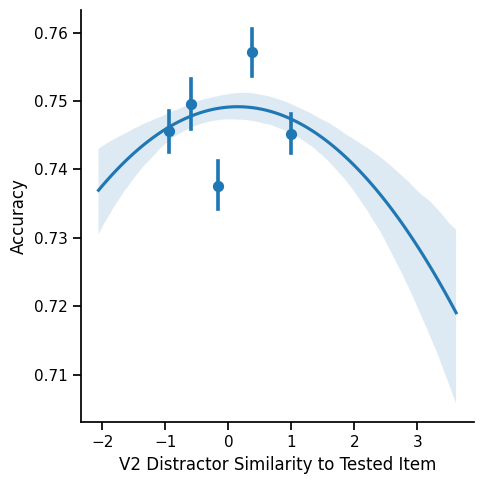

In [13]:
single_color = palette[0]  # Use the first color from the palette
single_color_palette = [single_color]


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    data=df
)

<Figure size 1000x600 with 0 Axes>

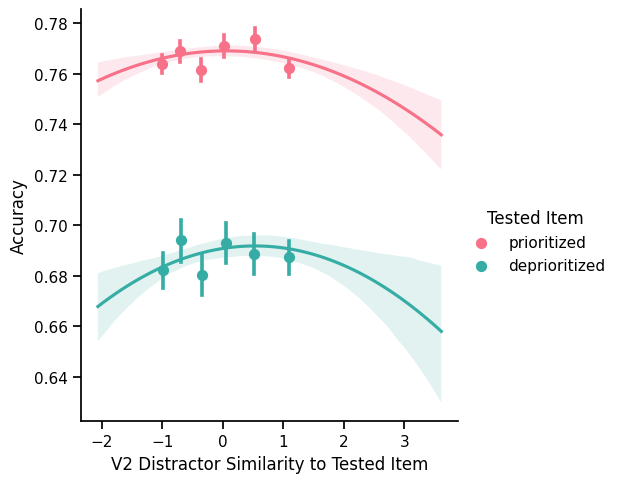

In [14]:


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)

<Figure size 1000x600 with 0 Axes>

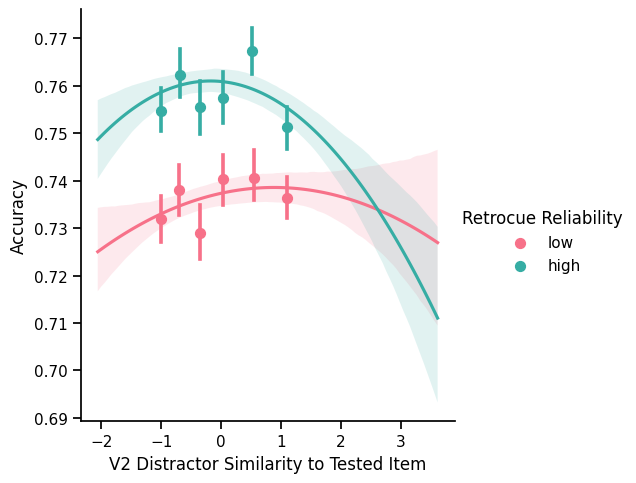

In [15]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)


<Figure size 1000x600 with 0 Axes>

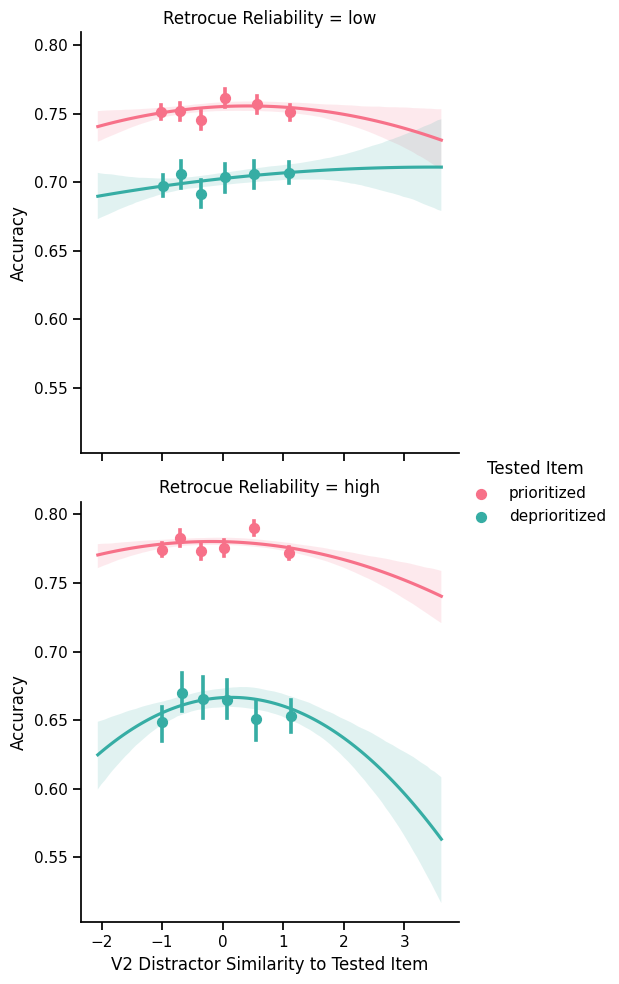

In [16]:


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    row = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order

    data=df
)


<Figure size 1000x600 with 0 Axes>

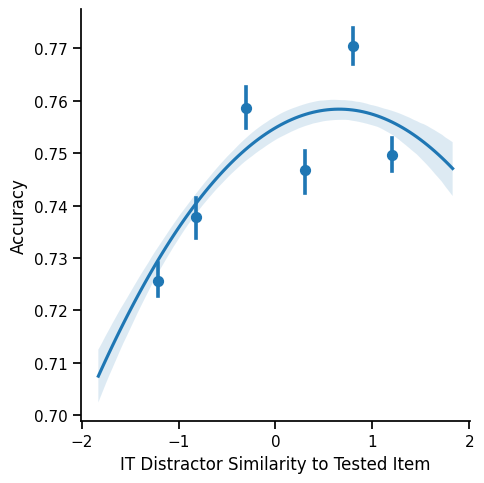

In [17]:


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

plt.show()

<Figure size 1000x600 with 0 Axes>

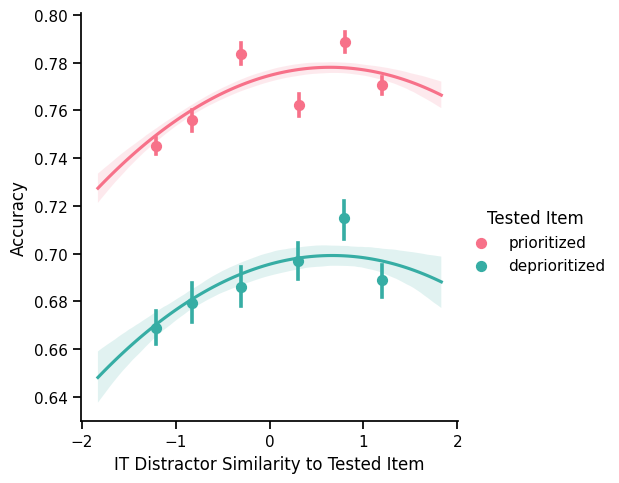

In [18]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)
plt.show()

<Figure size 1000x600 with 0 Axes>

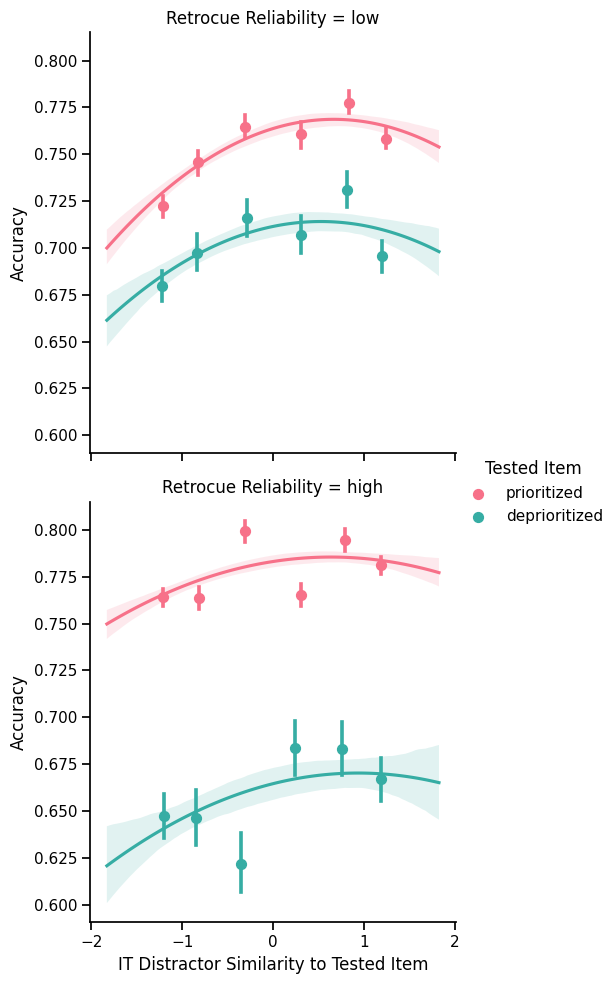

In [19]:


plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    row='Retrocue Reliability',  
    row_order = ['low', 'high'],
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


<Figure size 1000x600 with 0 Axes>

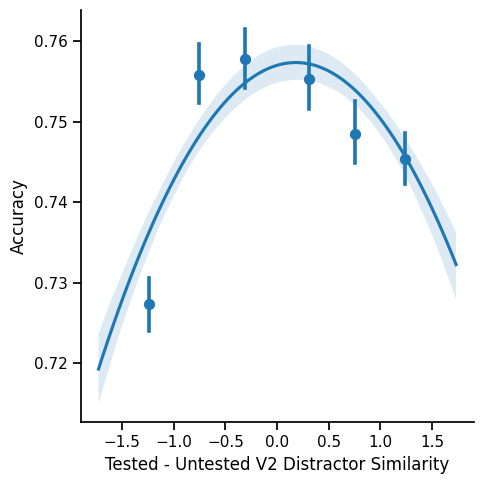

In [20]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
#     hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

<Figure size 1000x600 with 0 Axes>

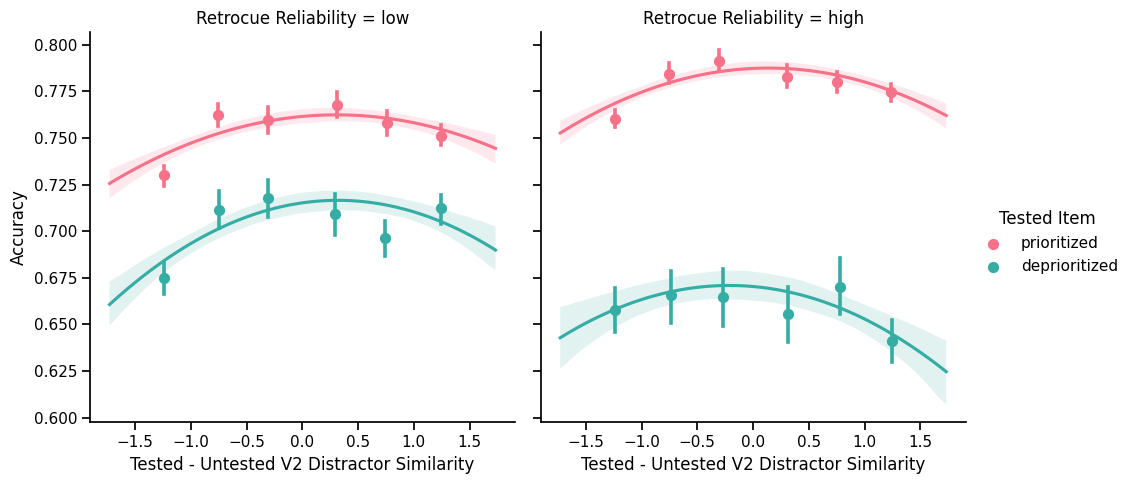

In [21]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue = 'Tested Item',

    col = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [22]:
# df_filtered_neg = df[df['Tested - Untested IT Distractor Similarity'] < 0]
# df_filtered_pos = df[df['Tested - Untested IT Distractor Similarity'] >= 0]

<Figure size 1000x600 with 0 Axes>

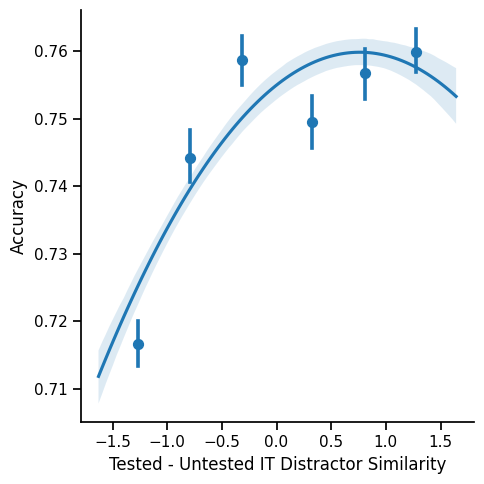

In [23]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
#     row = 'Retrocue Reliability',
#     hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


<Figure size 1000x600 with 0 Axes>

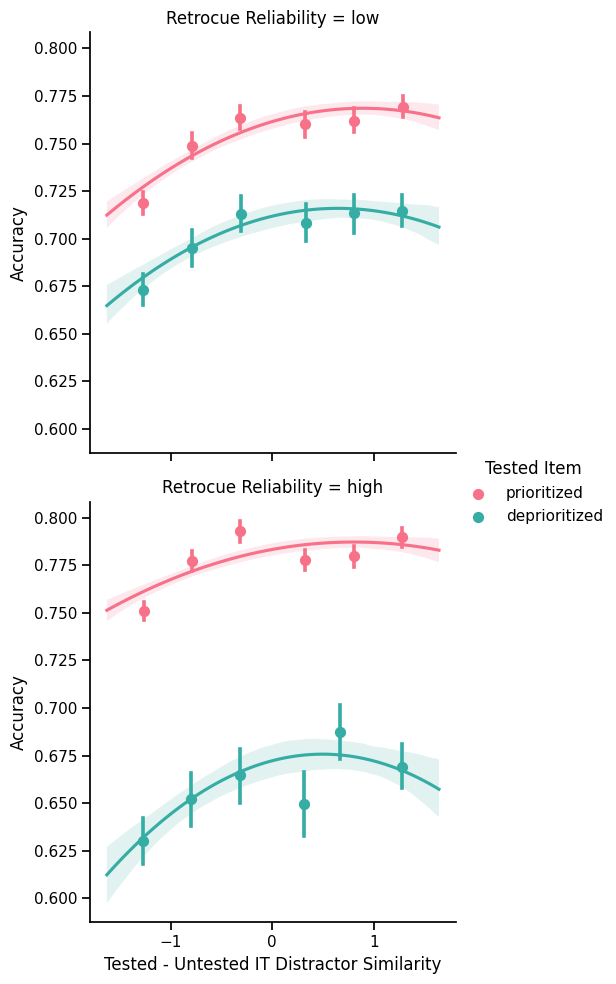

In [24]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


In [25]:
df_correct['Response Time'] = df_correct['analysis_rt']

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/1728104853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['Response Time'] = df_correct['analysis_rt']


<Figure size 1000x600 with 0 Axes>

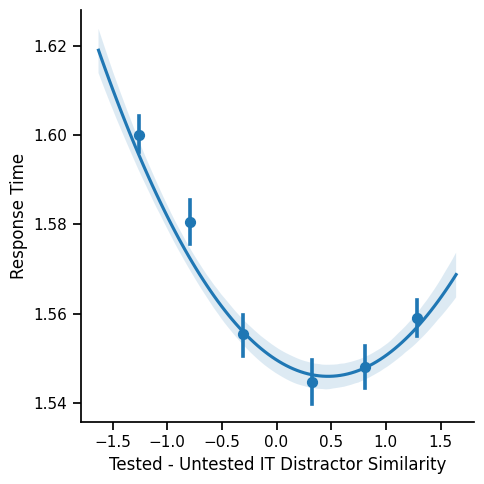

In [26]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Response Time',
#     row = 'Retrocue Reliability',
#     hue = 'Tested Item',
#     row_order = ['low', 'high'],
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)


<Figure size 1000x600 with 0 Axes>

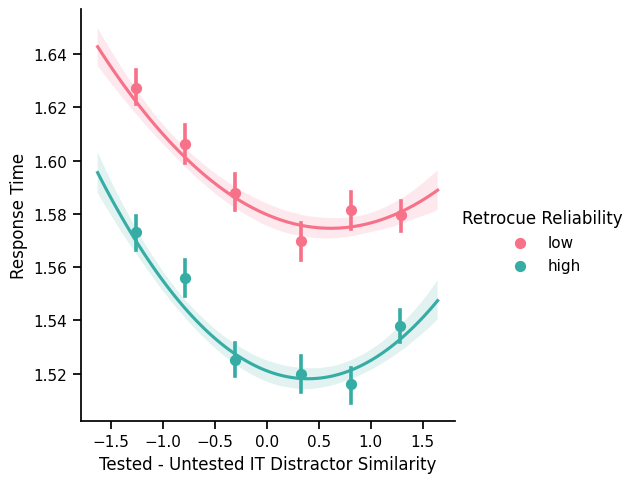

In [27]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Response Time',
    hue = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

<Figure size 1000x600 with 0 Axes>

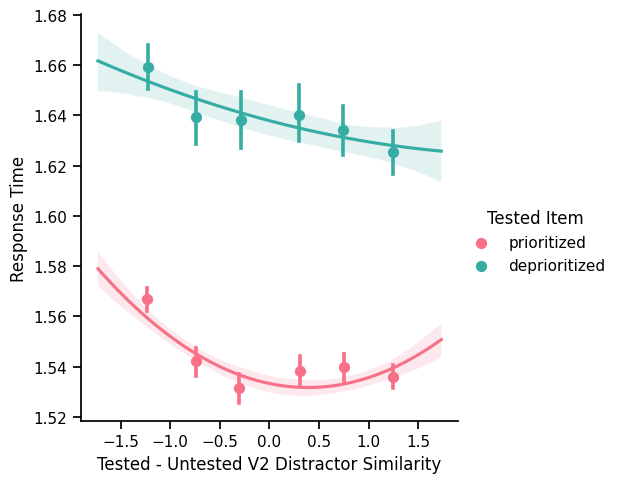

In [28]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Response Time',
    #row = 'Retrocue Reliability',
    hue = 'Tested Item',
    #row_order = ['low', 'high'],
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)


<Figure size 1000x600 with 0 Axes>

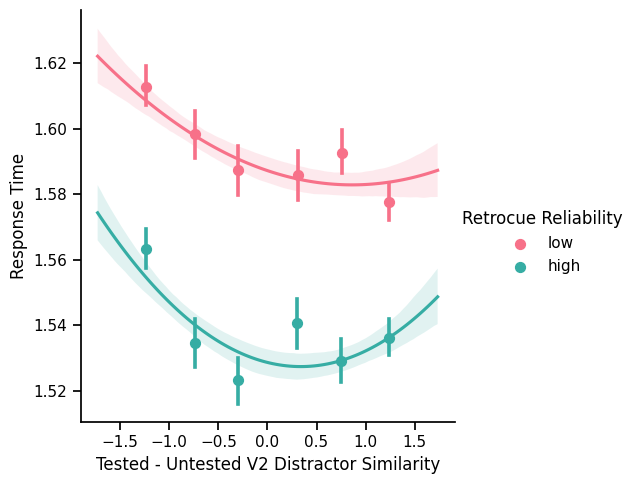

In [29]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Response Time',
    hue = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

<Figure size 1000x600 with 0 Axes>

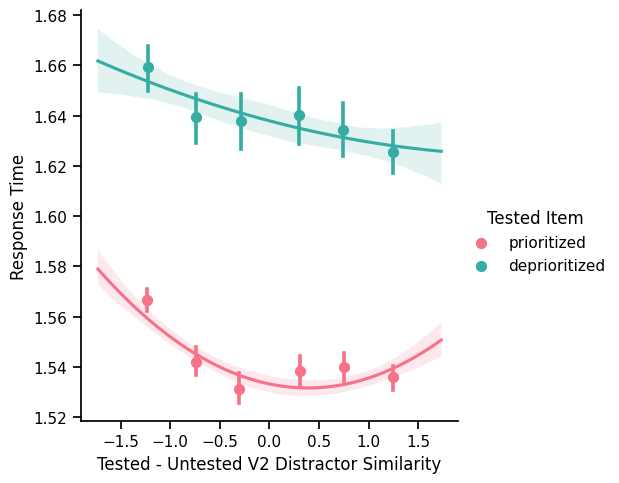

In [30]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Response Time',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

<Figure size 1000x600 with 0 Axes>

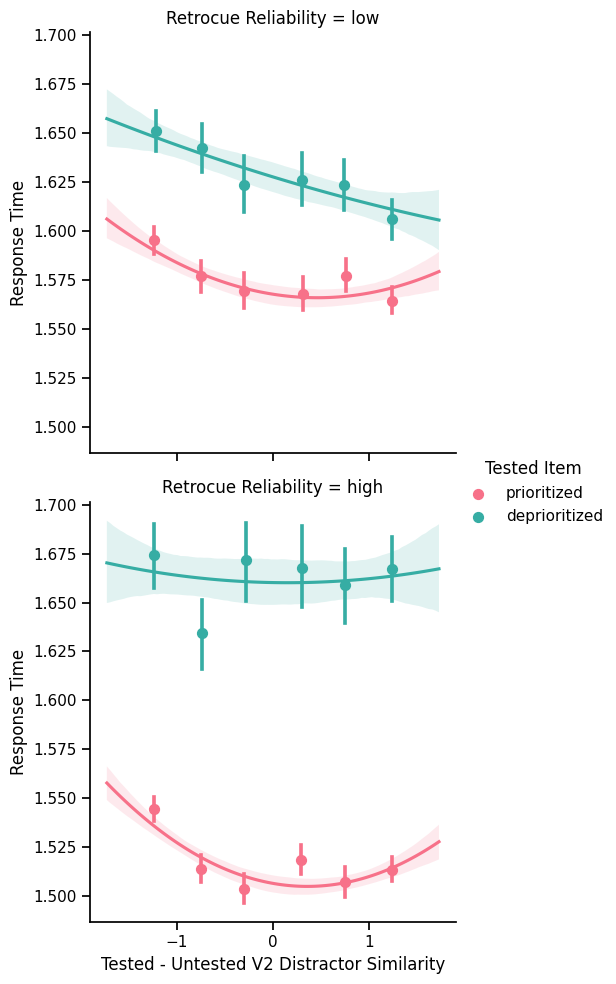

In [31]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Response Time',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    row_order = ['low', 'high'],
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)


<Figure size 1000x600 with 0 Axes>

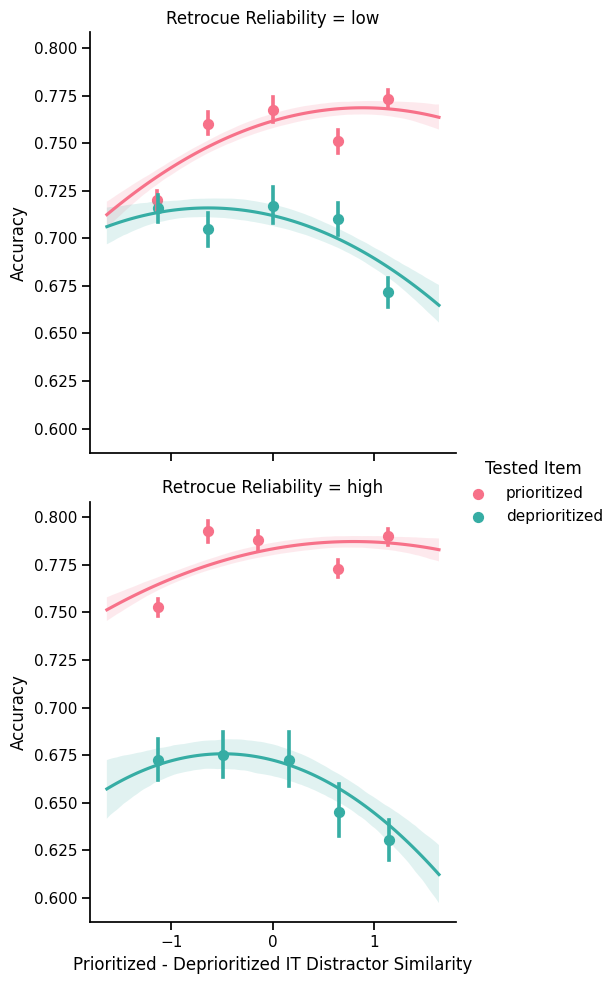

In [32]:

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Prioritized - Deprioritized IT Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)


<Figure size 1000x600 with 0 Axes>

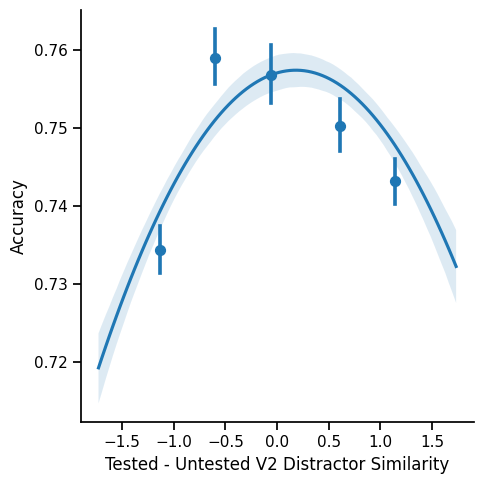

In [33]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

<Figure size 1000x600 with 0 Axes>

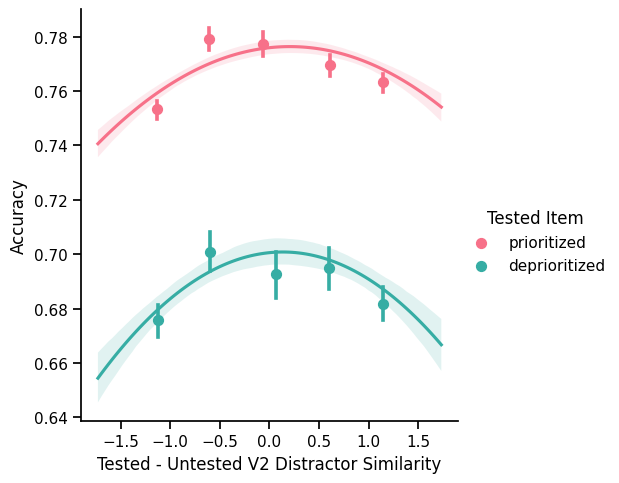

In [34]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue = 'Tested Item',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

<Figure size 1000x600 with 0 Axes>

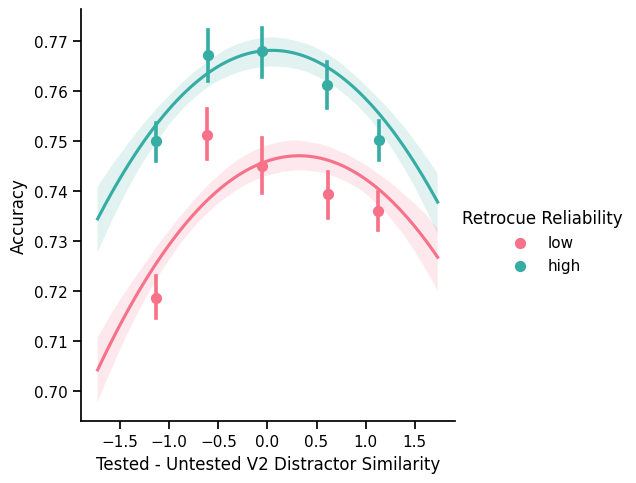

In [35]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue = 'Retrocue Reliability',
    x_bins = 5,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

<Figure size 1000x600 with 0 Axes>

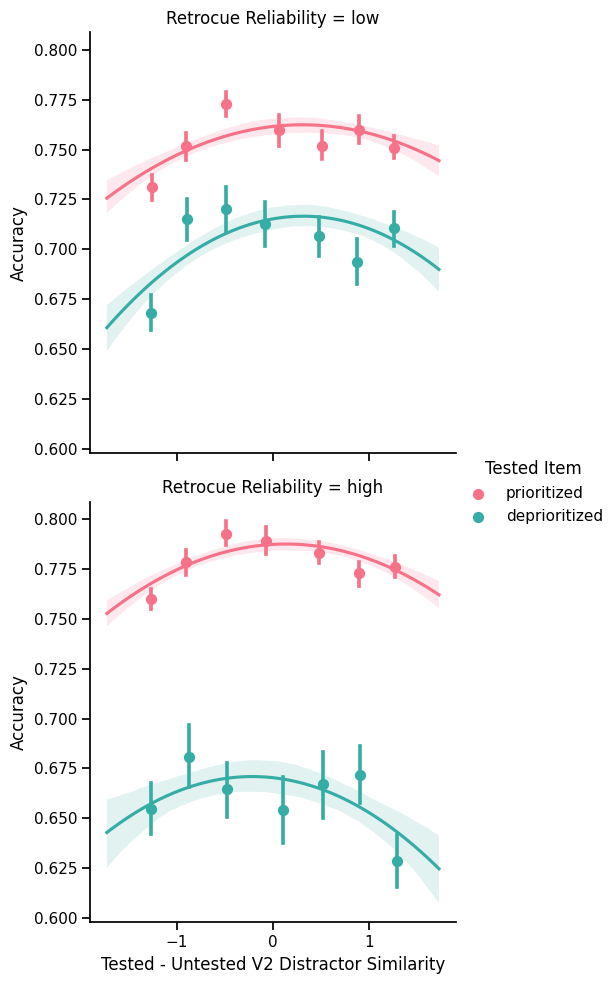

In [36]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 7,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [37]:
df['Tested Item']

0          prioritized
1          prioritized
2        deprioritized
3          prioritized
4        deprioritized
             ...      
82495    deprioritized
82496      prioritized
82497      prioritized
82498      prioritized
82499      prioritized
Name: Tested Item, Length: 82500, dtype: object

<Figure size 1000x600 with 0 Axes>

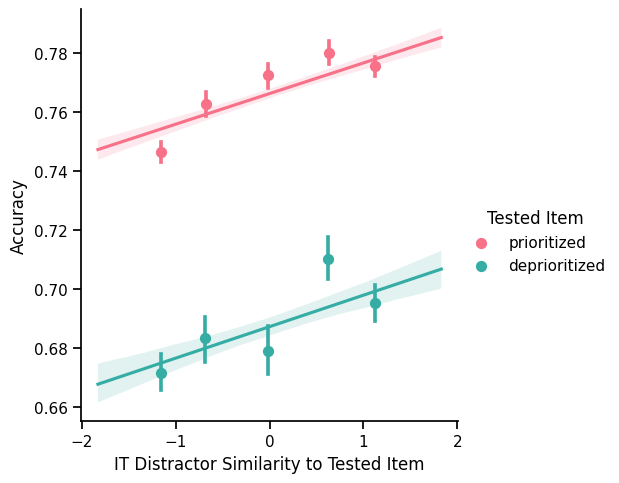

In [38]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
#     row = 'Retrocue Reliability',
    hue = 'Tested Item',
    x_bins = 5,
    order = 1,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df
)

In [39]:
# df['Prioritized - Deprioritized V2 Distractor Similarity Distance Ranges'] = pd.cut(df['it_sim_dis_diff'], bins=5)
# df['Prioritized - Deprioritized IT Distractor Similarity Distance Ranges'] = pd.cut(df['v2_sim_dis_diff'], bins=5)
# df['IT Distractor Similarity to Prioritized Item Distance Ranges'] = pd.cut(df['it_sim_dis_attend'], bins=5)
# df['V2 Distractor Similarity to Prioritized Item Distance Ranges'] =  pd.cut(df['v2_sim_dis_attend'], bins=5)
# df['Tested - Untested V2 Distractor Similarity Distance Ranges'] = pd.cut(df['it_sim_dis_diff_test'], bins=5)
# df['Tested - Untested IT Distractor Similarity Distance Ranges'] = pd.cut(df['v2_sim_dis_diff_test'], bins=5)
# df['IT Distractor Similarity to Tested Item Distance Ranges'] = pd.cut(df['it_sim_dis_test'], bins=5)
# df['V2 Distractor Similarity to Tested Item Distance Ranges'] = pd.cut(df['v2_sim_dis_test'], bins=5)



In [40]:
# df_it_prior_pos = df[df['it_sim_dis_diff'] >= 0]
# df_it_prior_neg = df[df['it_sim_dis_diff'] < 0]
# df_v2_prior_pos = df[df['v2_sim_dis_diff'] >= 0]
# df_v2_prior_neg = df[df['v2_sim_dis_diff'] < 0]

# df_it_test_pos = df[df['it_sim_dis_diff_test'] >= 0]
# df_it_test_neg = df[df['it_sim_dis_diff_test'] < 0]
# df_v2_test_pos= df[df['v2_sim_dis_diff_test'] >= 0]
# df_v2_test_neg = df[df['v2_sim_dis_diff_test'] < 0]

# df_it_prior_pos['IT_diff_binned_pos'] = pd.qcut(df_it_prior_pos['it_sim_dis_diff'], 5, duplicates='drop')


In [41]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test_z'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test_z'] <= 0, 0, 1)
df['it_pos_neg_abs'] =  np.where(df['it_sim_dis_test_z'] <= 0, 0, 1)
df['v2_pos_neg_abs'] =  np.where(df['v2_sim_dis_test_z'] <= 0, 0, 1)


In [42]:
len(df[df['it_pos_neg_abs'] == 0])

41892

In [43]:
len(df[df['it_pos_neg'] == 1])

40975

Text(0.5, 615.222222222222, '')

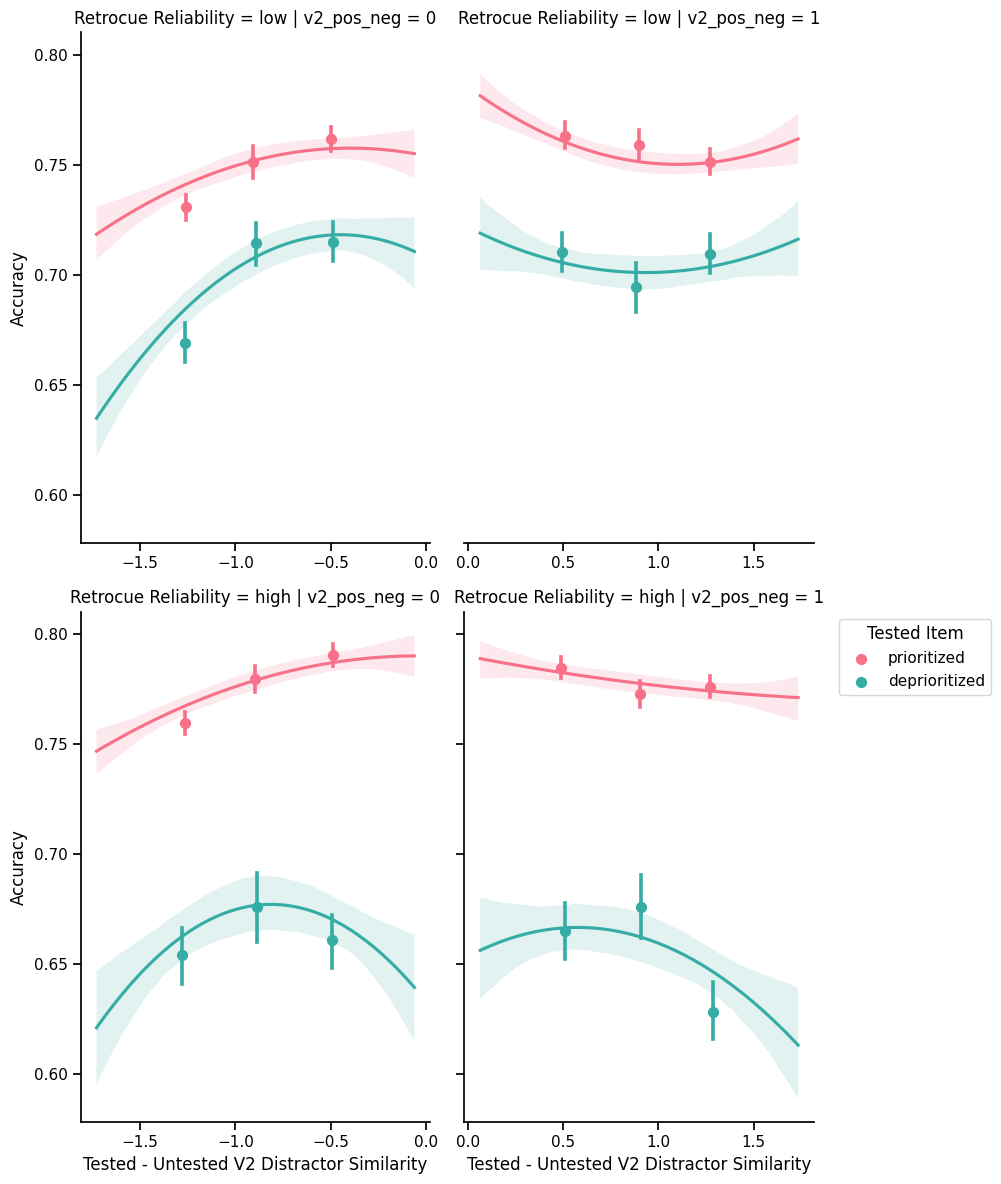

In [44]:
g = sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue='Tested Item',
    col='v2_pos_neg',
    row = 'Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)

g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')

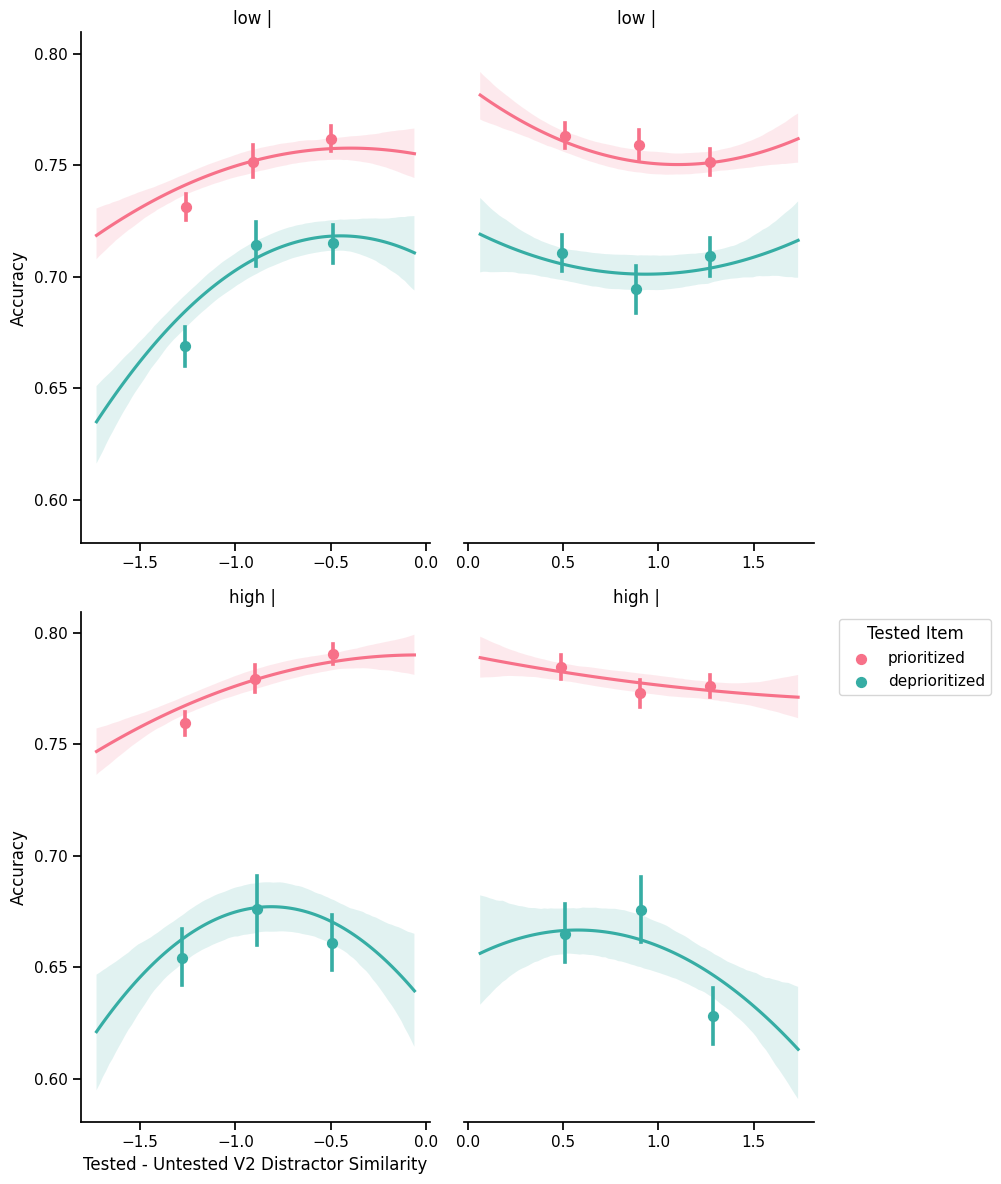

In [45]:
g = sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue='Tested Item',
    col='v2_pos_neg',
    row = 'Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)

# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')

plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 35.99999999999997, '')

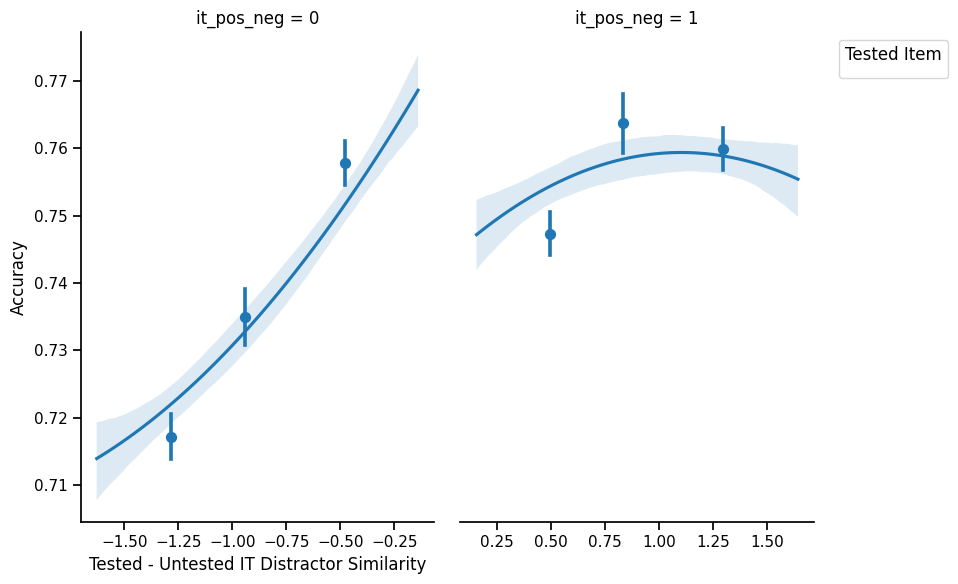

In [86]:
g = sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    # hue='Tested Item',
    col='it_pos_neg',
    # row = 'Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)

g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')

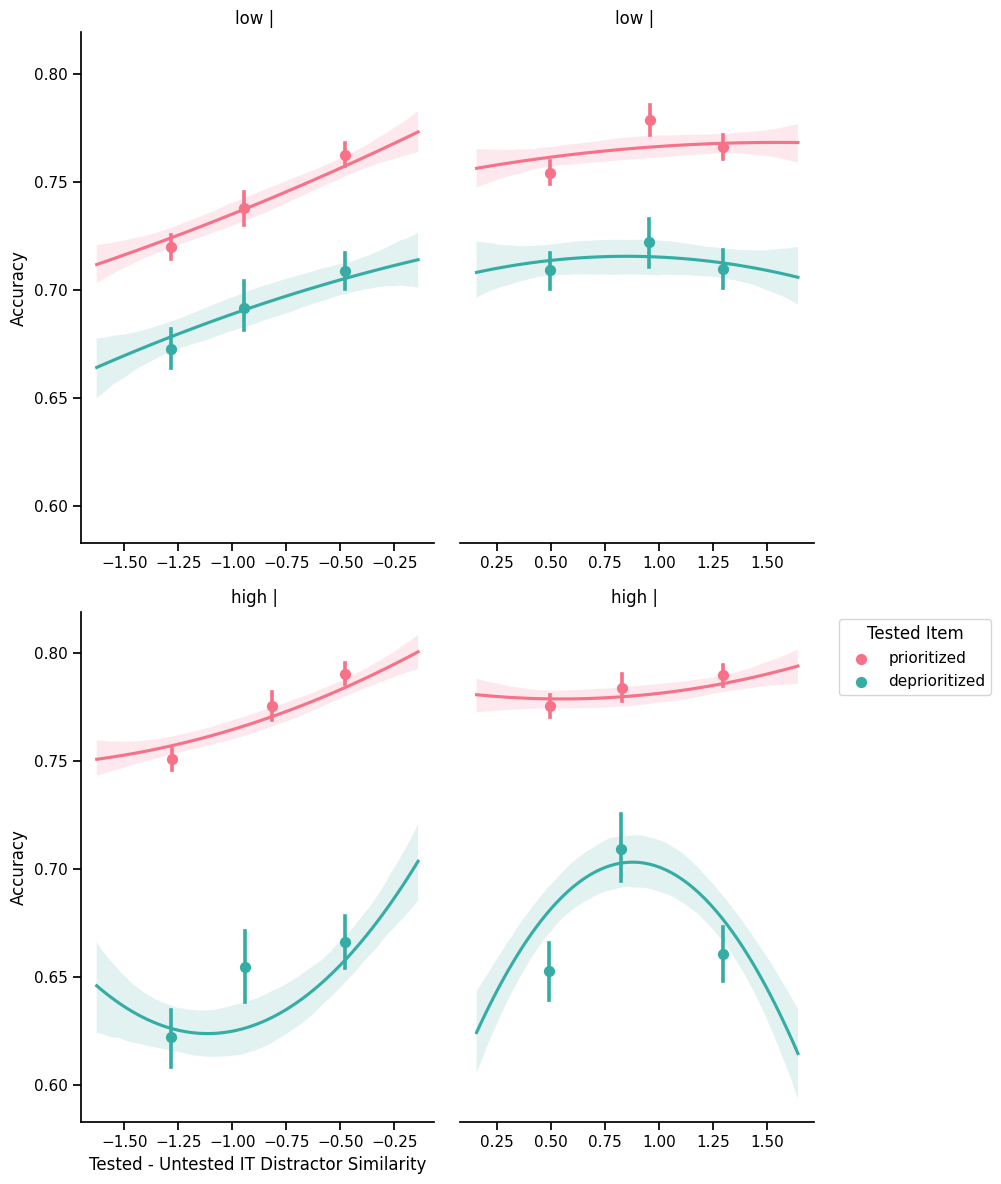

In [47]:
g = sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    hue='Tested Item',
    col='it_pos_neg',
    row = 'Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)

# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')

plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')

In [48]:
df_correct = df[df['resp_correct'] == 1]

In [49]:
df_correct = df[df['resp_correct'] == 1]
df_correct['Response Time'] = df_correct['analysis_rt']

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3838276257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['Response Time'] = df_correct['analysis_rt']


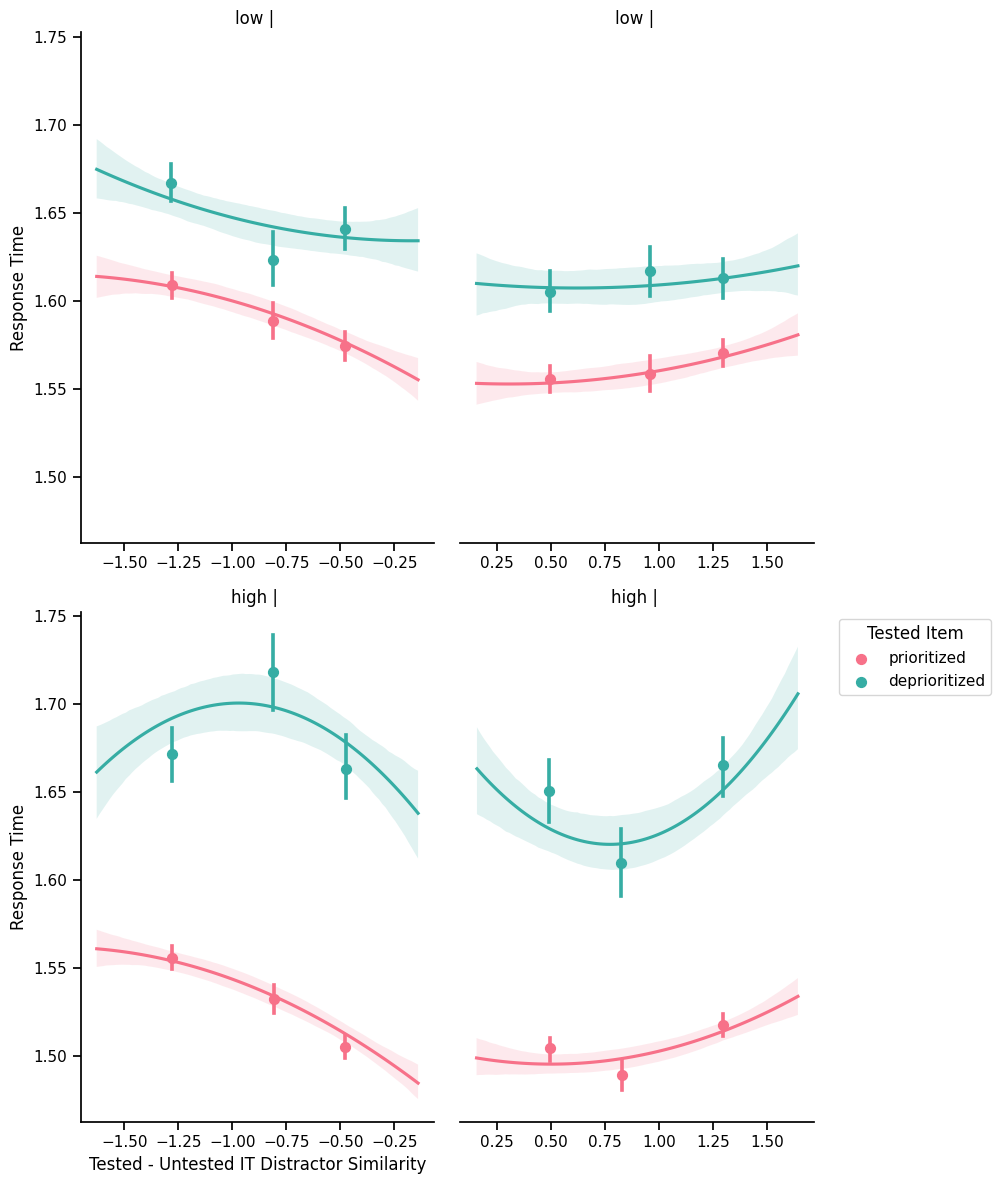

In [50]:
g = sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Response Time',
    hue='Tested Item',
    col='it_pos_neg',
    row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df_correct
)

# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


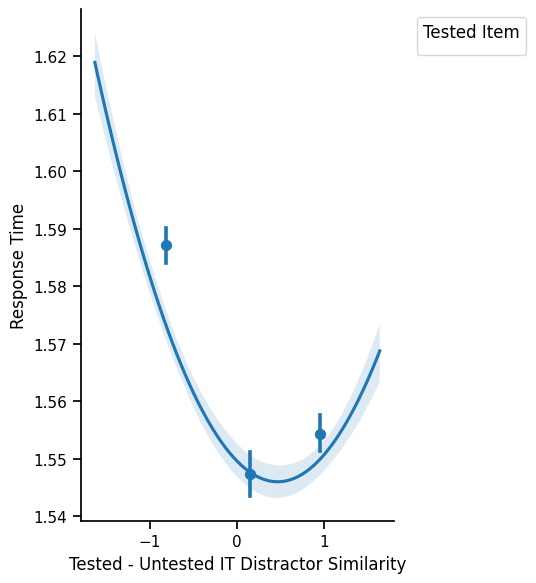

In [51]:
g = sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Response Time',
    # hue='Tested Item',
    # col='v2_pos_neg',
    # row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df_correct
)

# Remove y-axis and spine from right plots
# g.axes[0,1].yaxis.set_visible(False)
# g.axes[0,1].spines['left'].set_visible(False)
# g.axes[1,1].yaxis.set_visible(False)
# g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
# g.axes[0,1].set_xlabel('')
# g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')

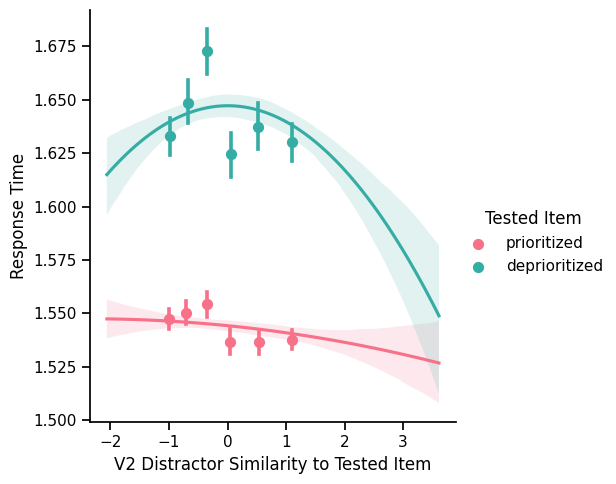

In [52]:
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Response Time',
    hue = 'Tested Item',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

Text(0.5, 615.222222222222, '')

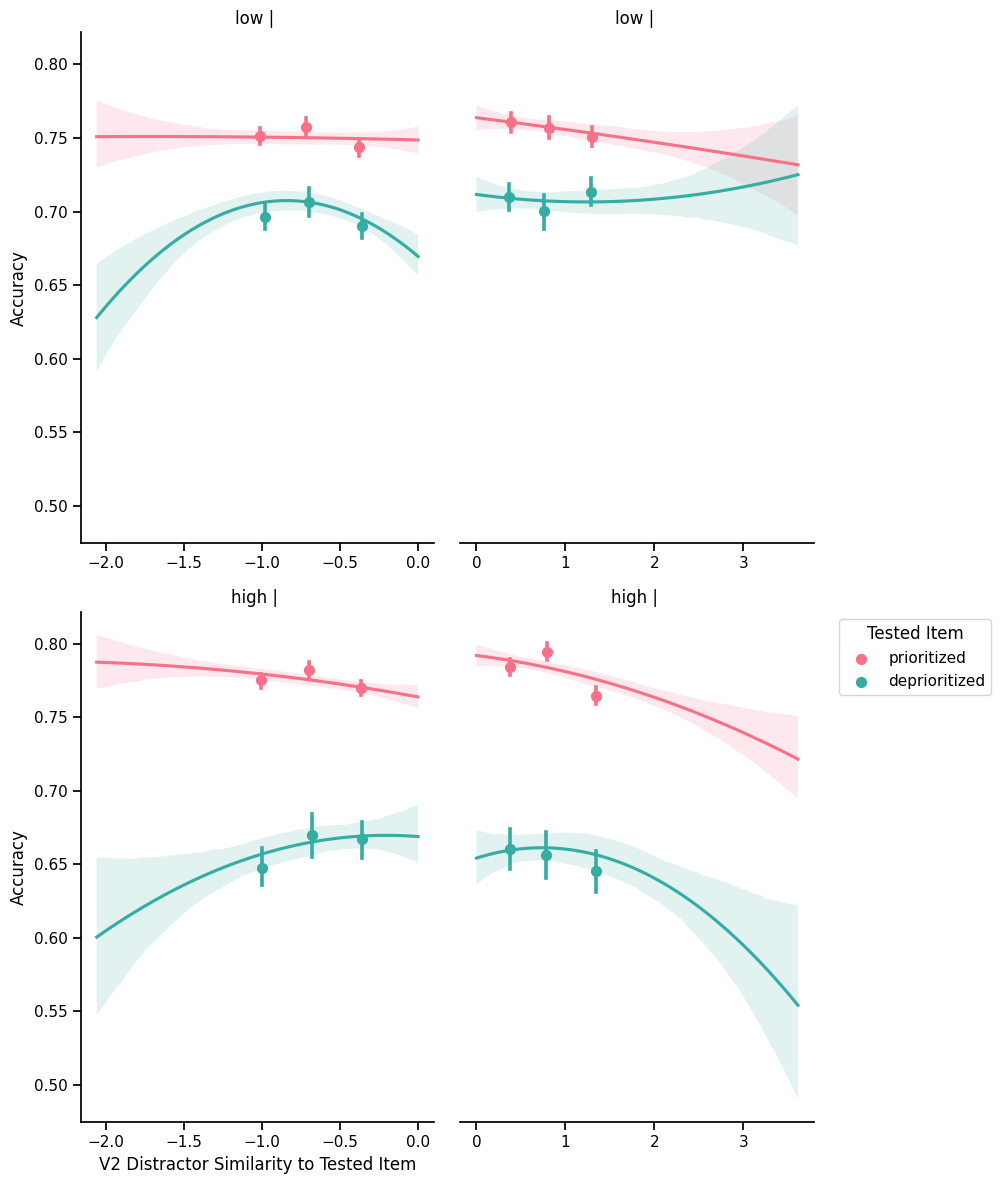

In [53]:
g = sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    col='v2_pos_neg_abs',
    row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)
# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')

Text(0.5, 615.222222222222, '')

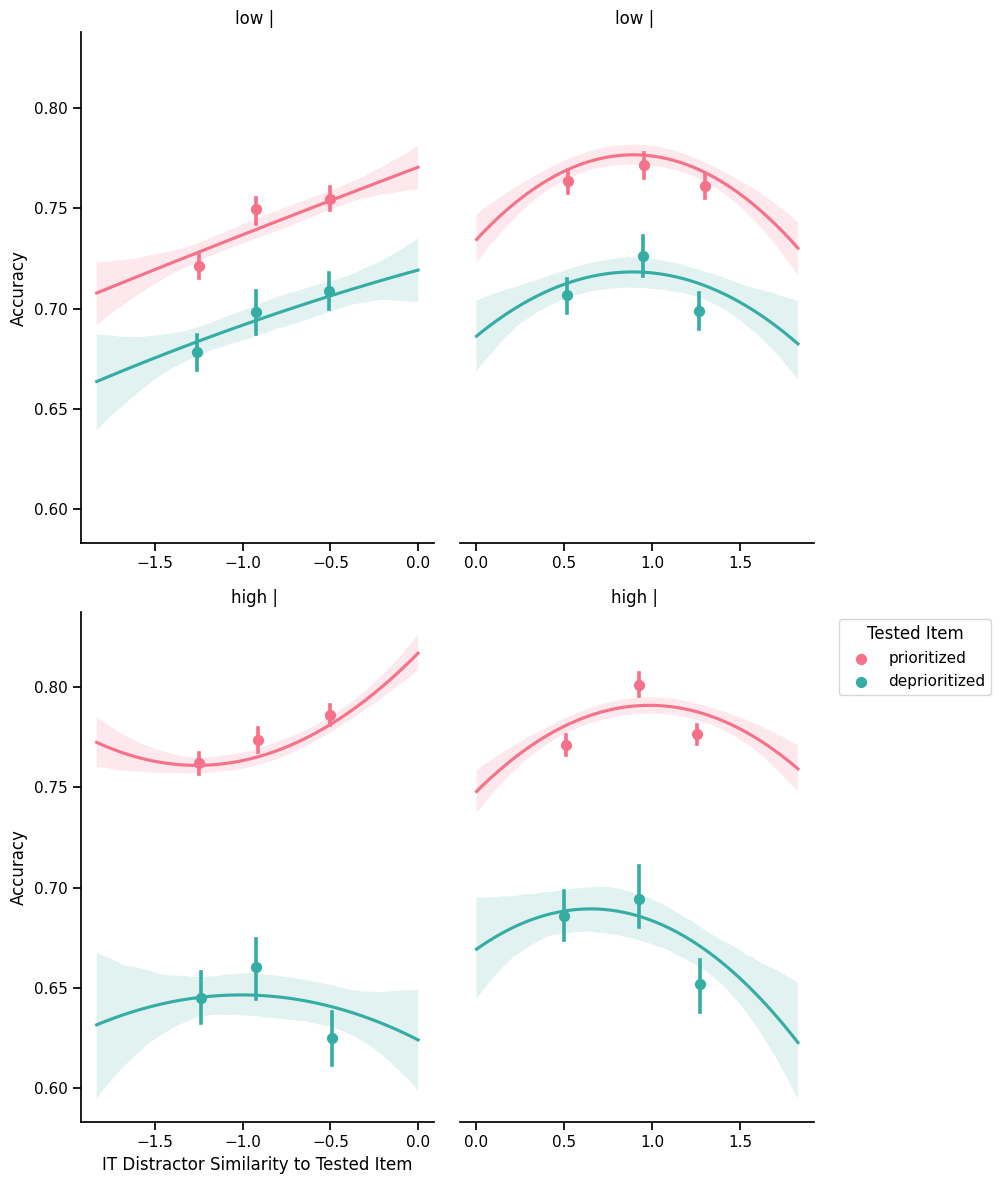

In [54]:
g = sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='Tested Item',
    col='it_pos_neg_abs',
    row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df
)
# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')

In [55]:
df_correct = df[df['resp_correct'] == 1]
df_correct['Response Time'] = df_correct['analysis_rt']

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3838276257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['Response Time'] = df_correct['analysis_rt']


Text(0.5, 615.222222222222, '')

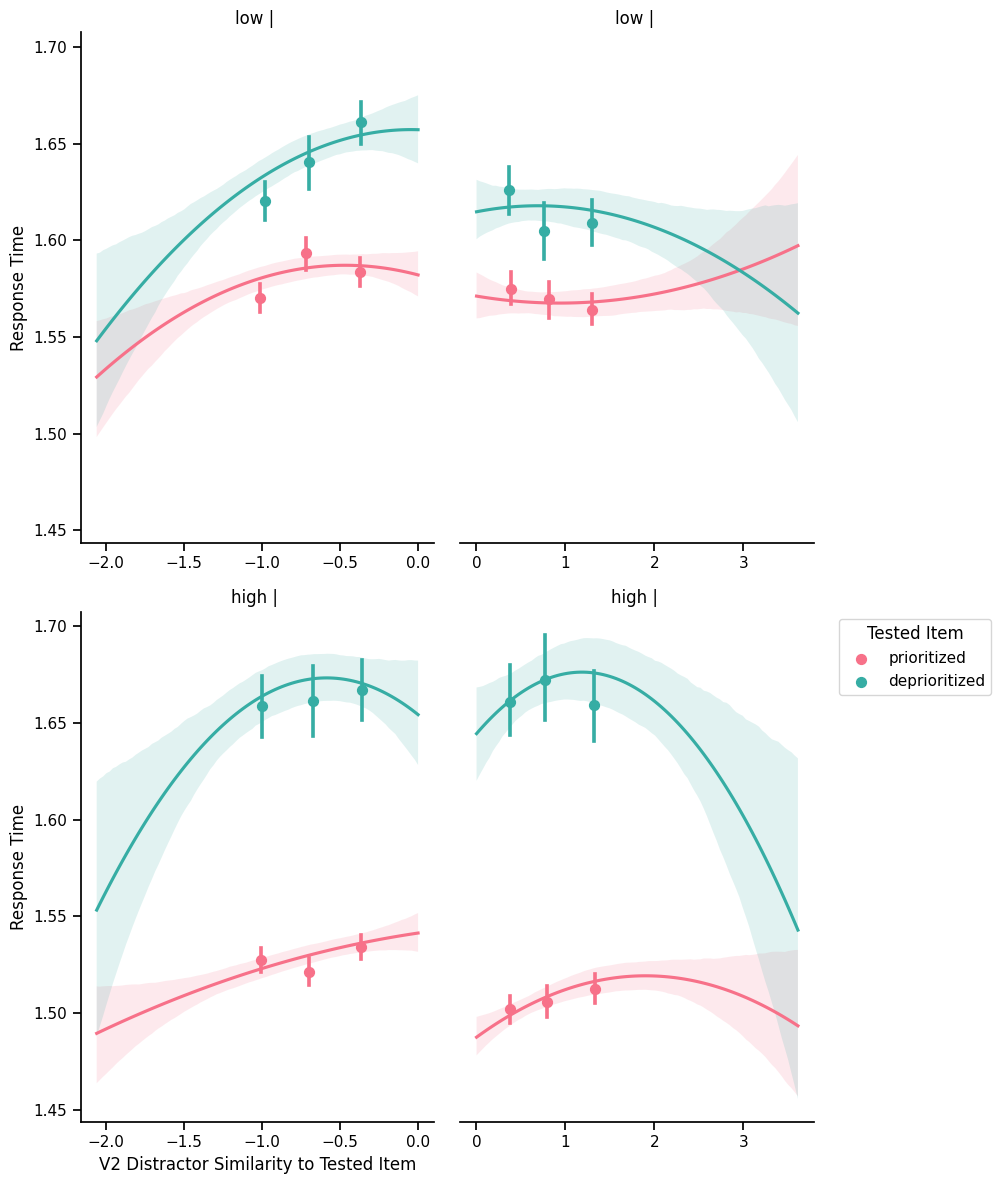

In [56]:
g = sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Response Time',
    hue='Tested Item',
    col='v2_pos_neg_abs',
    row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df_correct
)
# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')



Text(0.5, 615.222222222222, '')

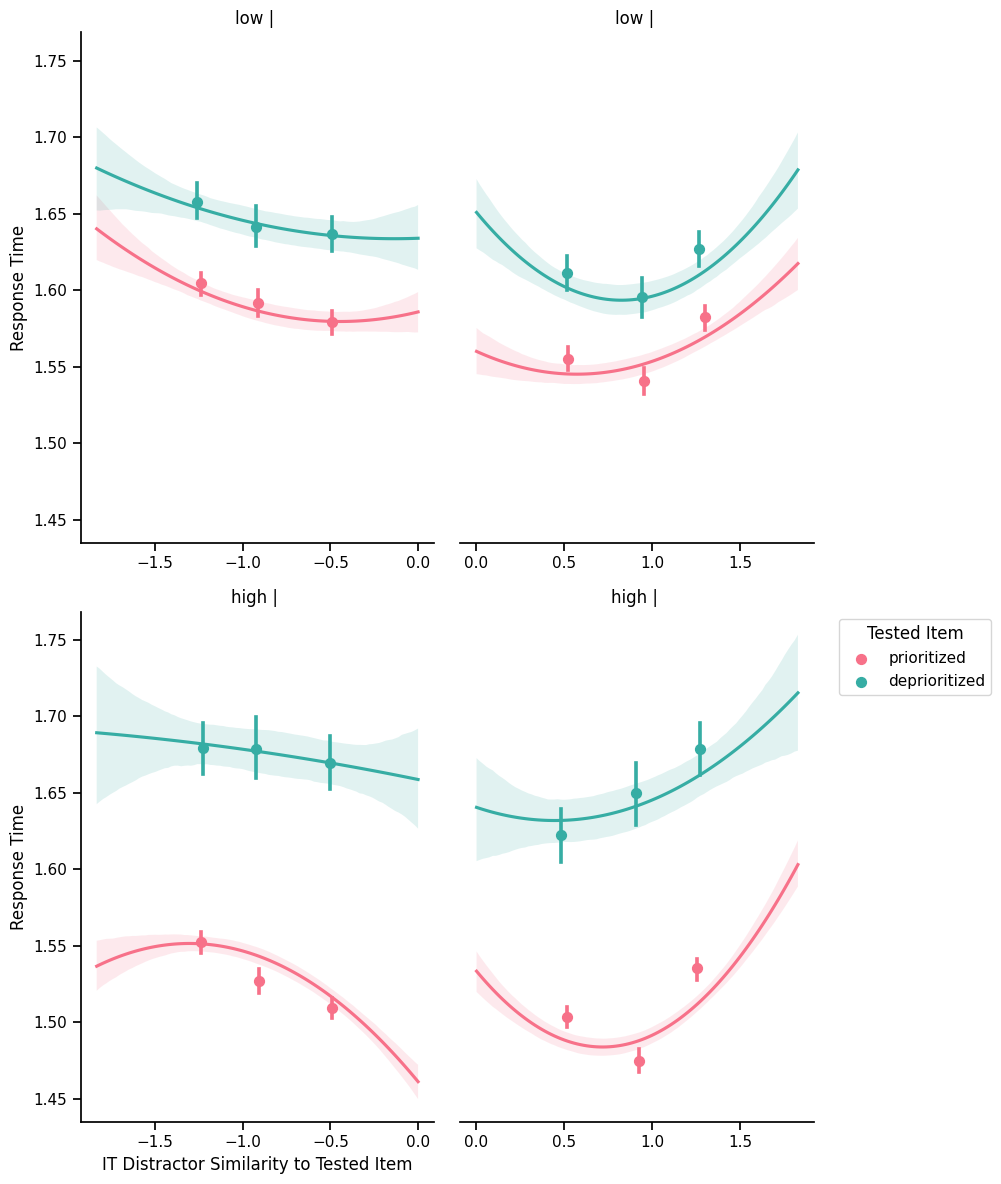

In [57]:
g = sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Response Time',
    hue='Tested Item',
    col='it_pos_neg_abs',
    row='Retrocue Reliability',
    x_bins=3,
    order=2,
    height=6,      
    aspect=0.7,   
    facet_kws={'sharex': False}, 
    ci=68,
    palette=palette[::-1],
    legend=False,
    data=df_correct
)
# Remove y-axis and spine from right plots
g.axes[0,1].yaxis.set_visible(False)
g.axes[0,1].spines['left'].set_visible(False)
g.axes[1,1].yaxis.set_visible(False)
g.axes[1,1].spines['left'].set_visible(False)

# Remove x-labels from right plots
g.axes[0,1].set_xlabel('')
g.axes[1,1].set_xlabel('')

# Remove column titles while keeping row titles
g.set_titles(col_template='', row_template='{row_name}')



plt.legend(title='Tested Item', bbox_to_anchor=(1.05, 1), loc='upper left')
g.axes[0,1].set_xlabel('')



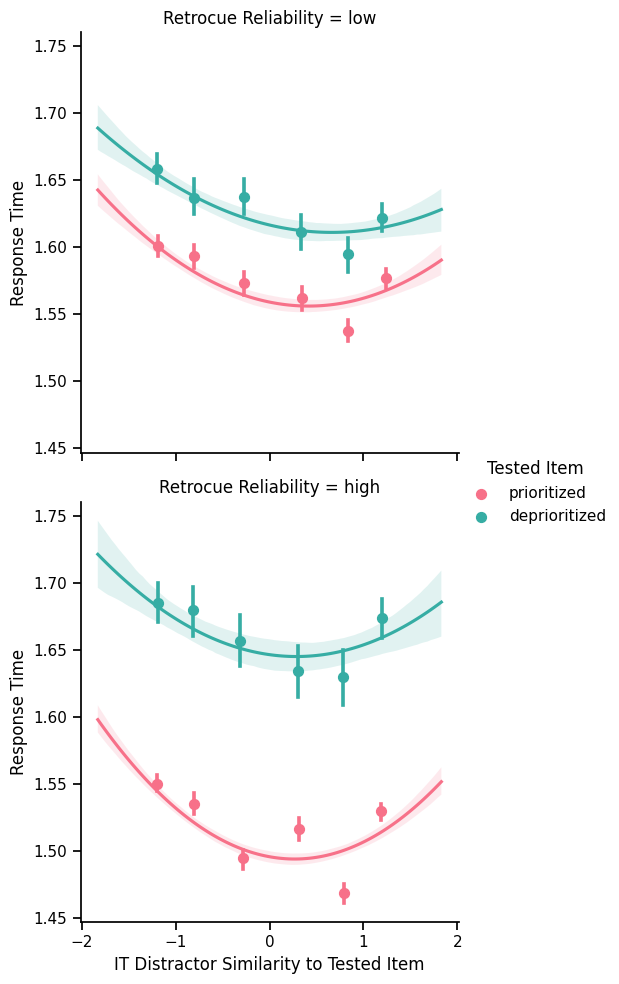

In [58]:
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Response Time',
    hue = 'Tested Item',
    row = 'Retrocue Reliability',
    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

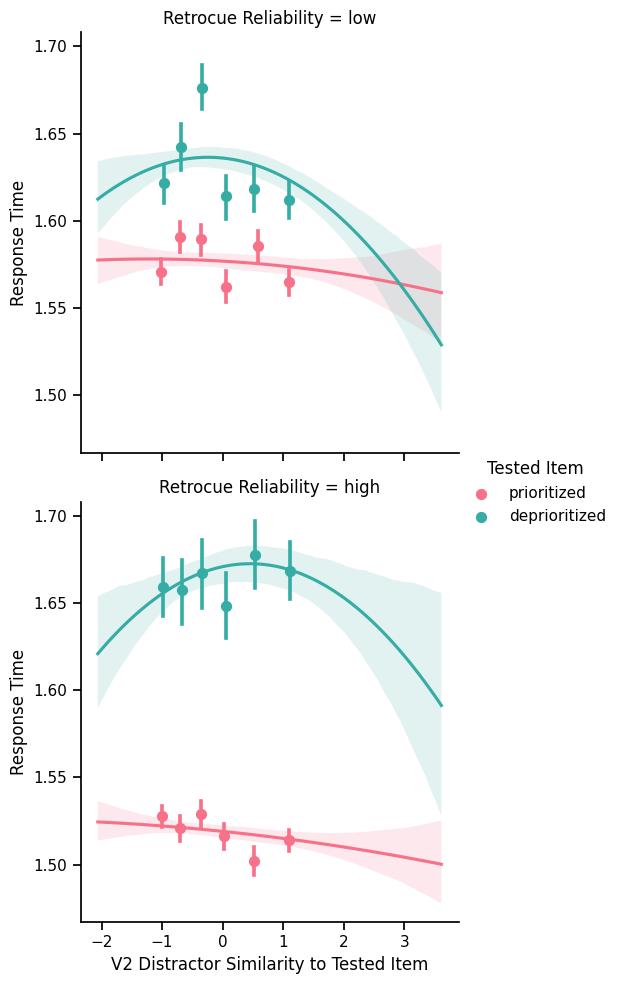

In [59]:
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Response Time',
    hue = 'Tested Item',
    row = 'Retrocue Reliability',

    x_bins = 6,
    order = 2,
    ci = 68,
    palette = palette[::-1],  # Reverse the color order
    data=df_correct
)

In [60]:
df['tested_memorability_resmem_z'] = scaler.fit_transform(df[['tested_memorability_resmem']])

In [61]:
# df.to_csv('pilot_TOTAL_TEST.csv', index=False)  # Set index=False to avoid saving row indices


In [62]:
scaler = StandardScaler()

df['it_pos_neg_abs_z'] =  scaler.fit_transform(df[['it_pos_neg_abs']])
df['v2_pos_neg_abs_z'] = scaler.fit_transform(df[['v2_pos_neg_abs']])
df['it_pos_neg_z'] = scaler.fit_transform(df[['it_pos_neg']])
df['v2_pos_neg_z'] = scaler.fit_transform(df[['v2_pos_neg']])

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/2383427685.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.catplot(


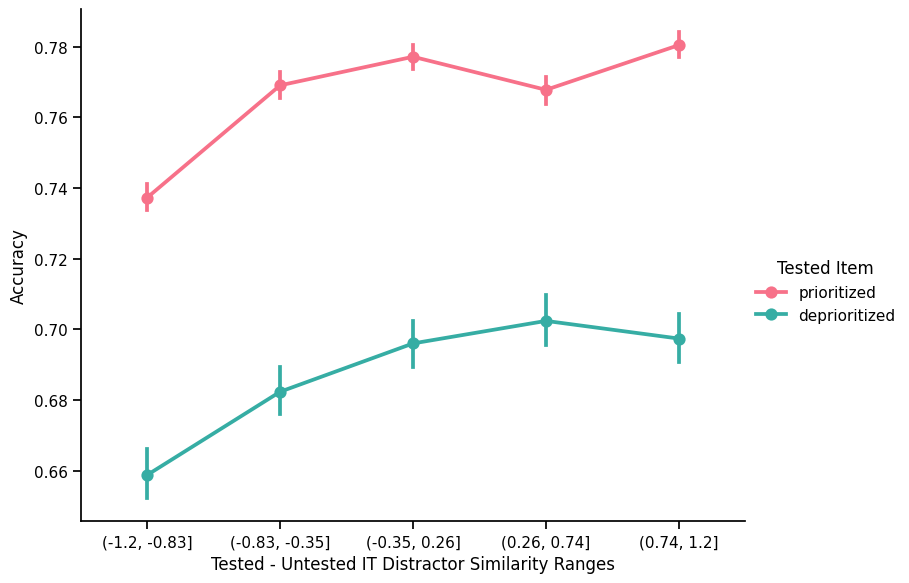

In [63]:

df['pilot_type'] = np.where(df['pilot_number'] == 1, 'new stimuli', 'old stimuli')

sns.catplot(
    data=df,
    x='Tested - Untested IT Distractor Similarity Ranges',
    y='Accuracy',
    hue='Tested Item',
#         col = 'pilot_type',

#     col='Retrocue Reliability',
#     col_order = ['low', 'high'],
    kind='point',
    ci=68,
    palette=palette[::-1],
    height=6,
    aspect=1.3
)

In [64]:
### instead of Prioritized-Deprioritized similarity on x axis, get (both relative and absolute)
# Similarity to Tested item and then split by prioritzed - x axis will be relative to tested/untested instead of prioritized/deprioritized

In [65]:
df['tested_memorability_resmem']

0        0.821004
1        0.890449
2        0.972881
3        0.846955
4        0.817970
           ...   
82495    0.819682
82496    0.901505
82497    0.790799
82498    0.937952
82499    0.936727
Name: tested_memorability_resmem, Length: 82500, dtype: float64

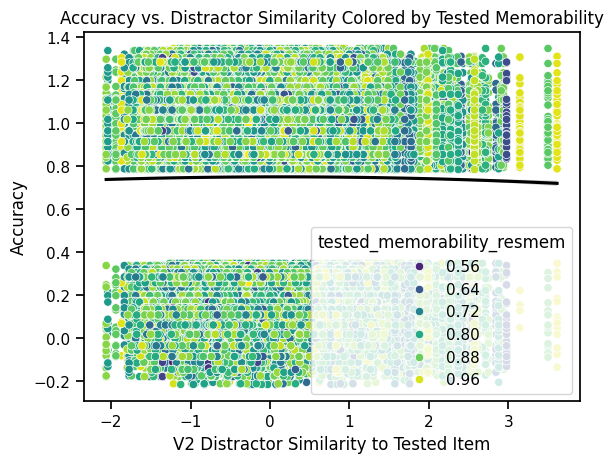

In [66]:
sns.scatterplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability_resmem',        # Numeric
    palette='viridis',               # Continuous colormap
    data=df
)

sns.regplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    order=2,
    ci=68,
    scatter=False,                   # Don't re-draw points
    color='black',
    data=df
)

plt.title("Accuracy vs. Distractor Similarity Colored by Tested Memorability")
plt.show()

In [67]:
df['tested_memorability_binned'] = pd.qcut(df['tested_memorability_resmem'], q=3, 
                                           labels=['Low','Medium', 'High'])


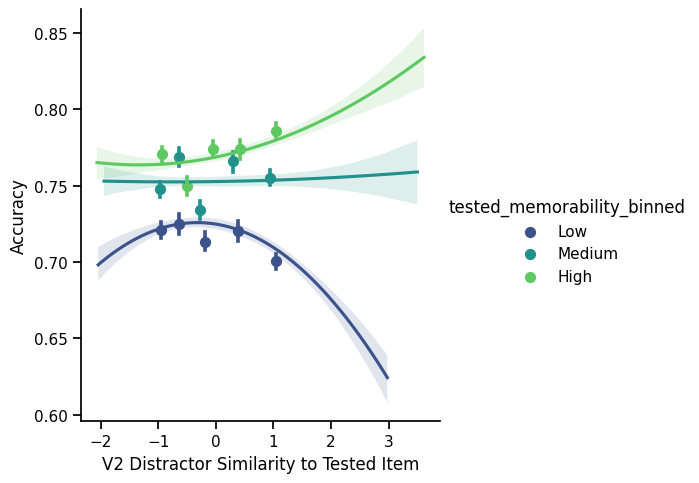

In [68]:
sns.lmplot(
    x='V2 Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

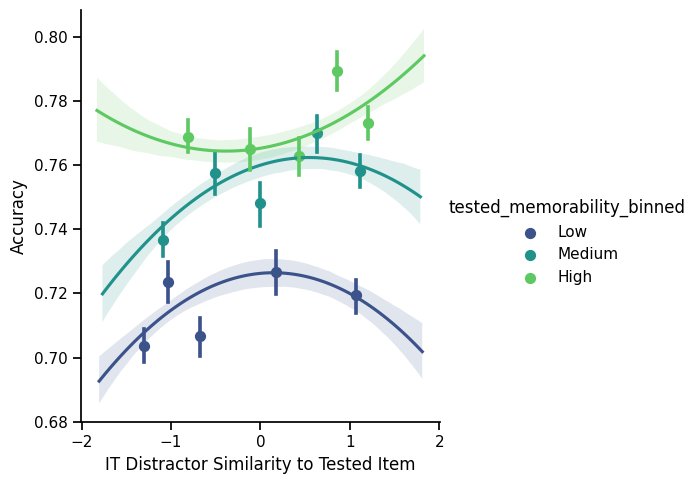

In [69]:
sns.lmplot(
    x='IT Distractor Similarity to Tested Item',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

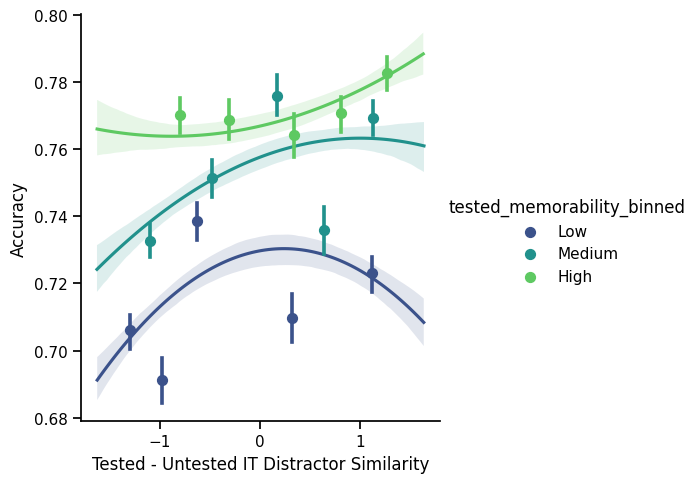

In [70]:
sns.lmplot(
    x='Tested - Untested IT Distractor Similarity',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

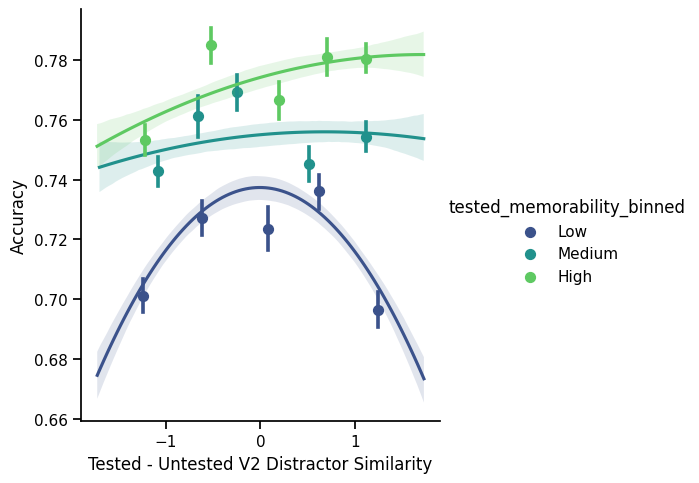

In [71]:
sns.lmplot(
    x='Tested - Untested V2 Distractor Similarity',
    y='Accuracy',
    hue='tested_memorability_binned',  # Now it's categorical
    x_bins=5,
    order=2,
    ci=68,
    palette='viridis',
    data=df
)
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3387455507.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


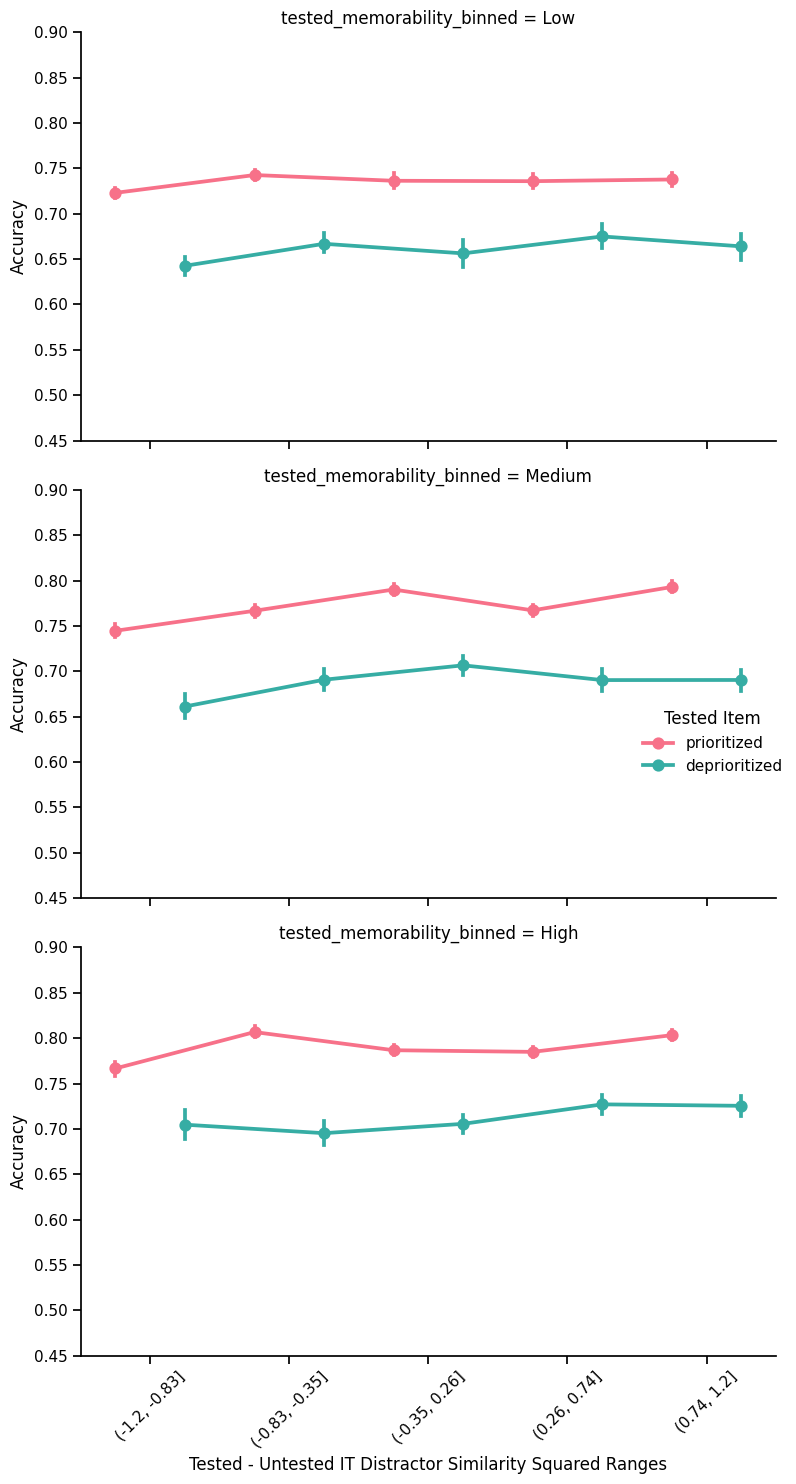

In [72]:

g = sns.catplot(
    x='Tested - Untested IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='tested_memorability_binned',  # Use 'row' instead of 'col'
    aspect=1.3,
#     row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.45, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Tested - Untested IT Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/4190826694.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


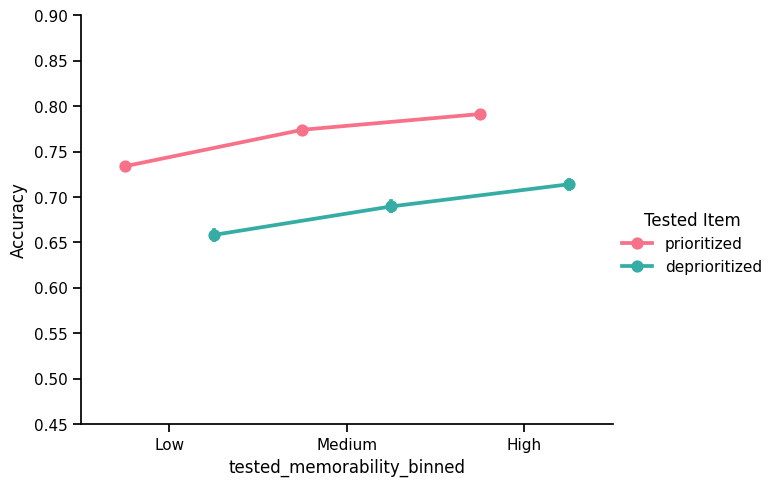

In [73]:
g = sns.catplot(
    x='tested_memorability_binned',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
#     row='Retrocue Reliability',
    aspect=1.3,
#     row_order = ['low', 'high'],
    dodge=0.5,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.45, 0.9))


In [74]:
df['Tested Item Memorability'] = df['tested_memorability_binned']

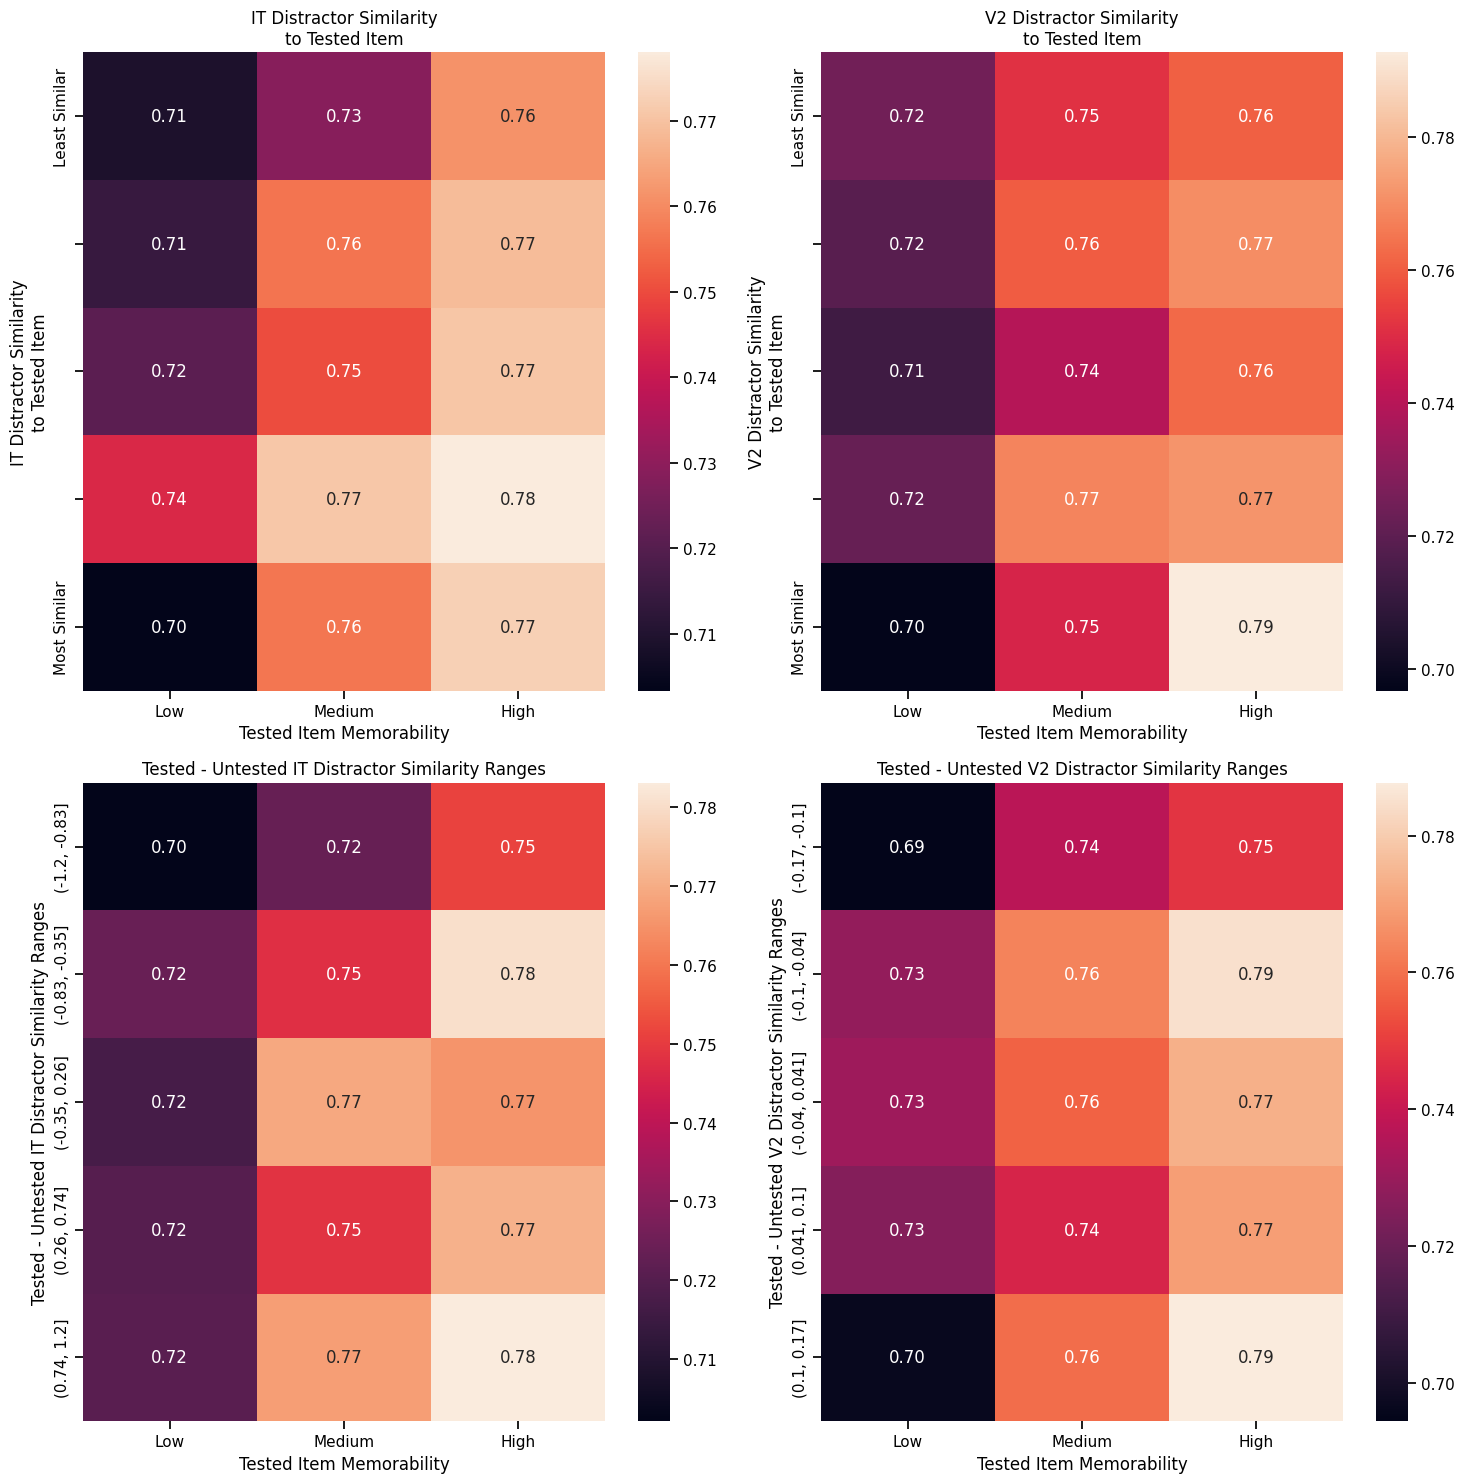

In [75]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# List of similarity metrics
similarity_metrics = [
    'IT Distractor Similarity\nto Tested Item',
    'V2 Distractor Similarity\nto Tested Item',
    'Tested - Untested IT Distractor Similarity Ranges',
    'Tested - Untested V2 Distractor Similarity Ranges'
]

# Create heatmaps
axes = [ax1, ax2, ax3, ax4]
for ax, metric in zip(axes, similarity_metrics):
    # Create pivot table
    heatmap_data = df.pivot_table(
        values='Accuracy',
        index=metric,
        columns='Tested Item Memorability',
        aggfunc='mean'
    )
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.2f',
        #cmap='RdYlBu_r',
        ax=ax
    )
    
    # Set title
    ax.set_title(metric)

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3617249075.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.pointplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3617249075.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3617249075.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564/3617249075.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.pointplot(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38564

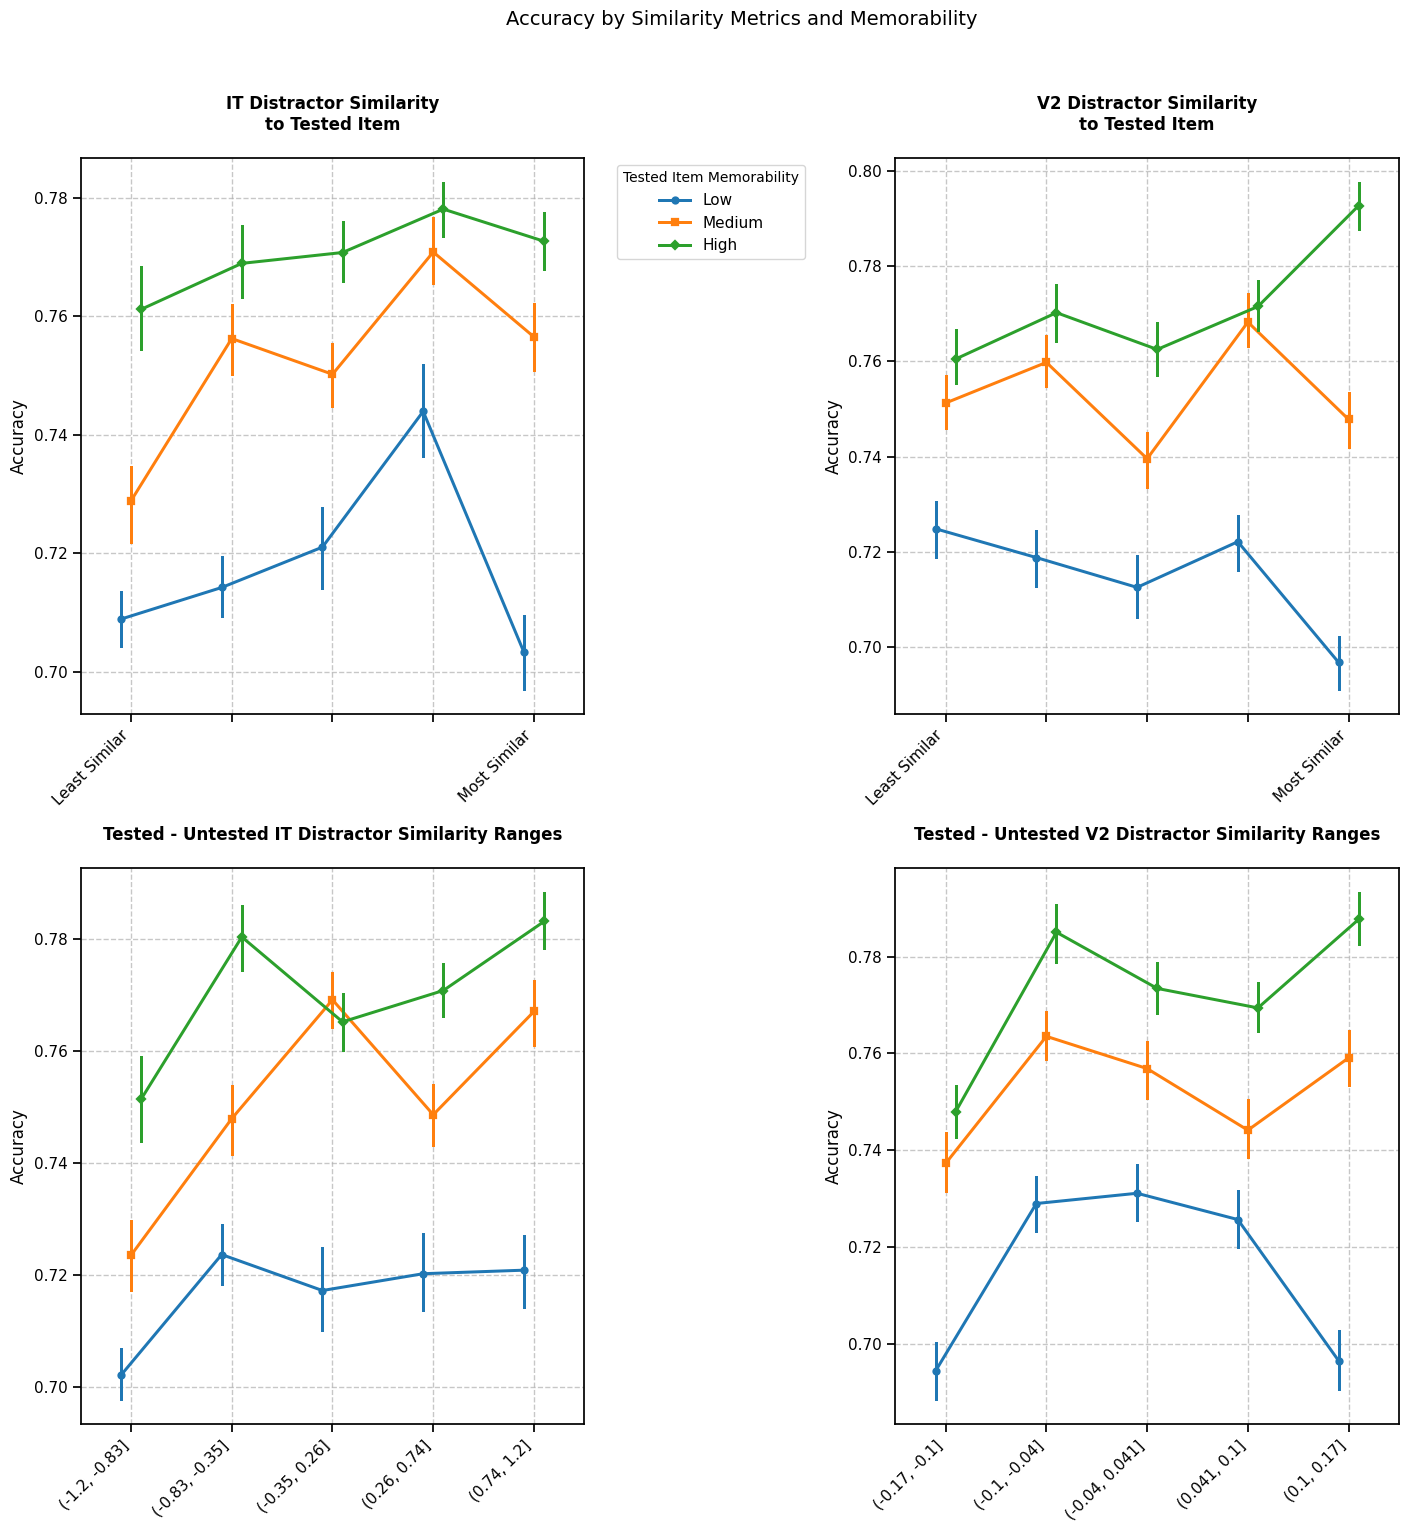

In [76]:
# Set figure size and create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# List of similarity metrics
similarity_metrics = [
    'IT Distractor Similarity\nto Tested Item',
    'V2 Distractor Similarity\nto Tested Item',
    'Tested - Untested IT Distractor Similarity Ranges',
    'Tested - Untested V2 Distractor Similarity Ranges'
]

# Create point plots
axes = [ax1, ax2, ax3, ax4]
for ax, metric in zip(axes, similarity_metrics):
    sns.pointplot(
        x=metric,
        y='Accuracy',
        hue='Tested Item Memorability',
        data=df,
        dodge=0.2,
        ci=68,
        ax=ax,
        markers=['o', 's', 'D', '^', 'v'],  # Different markers for each category
        scale=0.8,  # Adjust point size
        #legend=False if ax != ax1 else True
    )
    
    # Customize each subplot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(metric, pad=20, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('')  # Remove x-label as it's in the title
    
    # Remove legend if not the first plot
    if ax != ax1:
        ax.get_legend().remove()

# Move legend outside for first subplot
legend = ax1.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Tested Item Memorability',
    title_fontsize=10,
    frameon=True
)

# Add main title
fig.suptitle('Accuracy by Similarity Metrics and Memorability', fontsize=14, y=1.02)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Make room for legend
plt.show()

<Axes: xlabel='Tested Item Memorability', ylabel='Accuracy'>

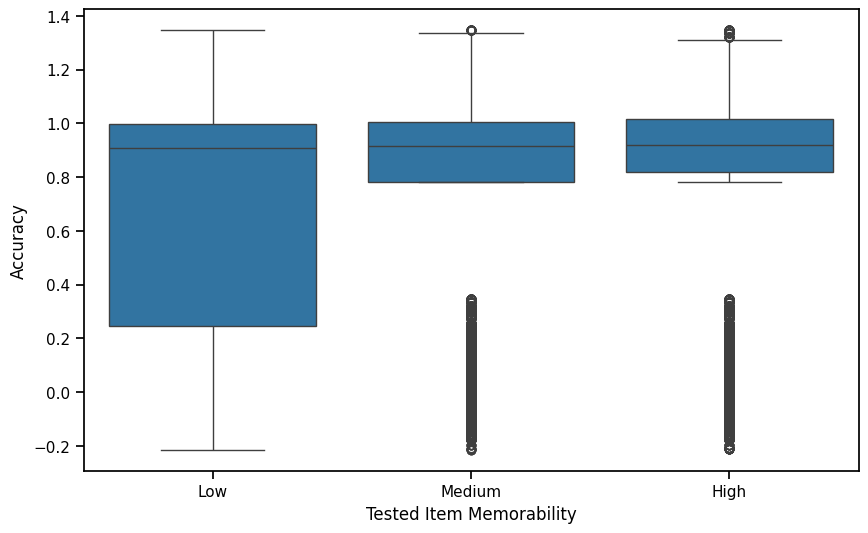

In [77]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Tested Item Memorability',
    y='Accuracy',
    data=df
)

In [78]:
# df['Tested Item Memorability - Distance split'] = pd.cut(df['tested_memorability_resmem'], bins=5)


In [79]:
# counts = df['Tested Item Memorability - Distance split'].value_counts()
# plt.figure(figsize=(10, 10))
# plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
# plt.title('Distribution of Items Across Memorability Bins')

In [80]:
# # Create a figure with 2x2 subplots
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# # List of similarity metrics
# similarity_metrics = [
#     'IT Distractor Similarity\nto Tested Item',
#     'V2 Distractor Similarity\nto Tested Item',
#     'Tested - Untested IT Distractor Similarity Ranges',
#     'Tested - Untested V2 Distractor Similarity Ranges'
# ]

# # Create heatmaps
# axes = [ax1, ax2, ax3, ax4]
# for ax, metric in zip(axes, similarity_metrics):
#     # Create pivot table
#     heatmap_data = df.pivot_table(
#         values='Accuracy',
#         index=metric,
#         columns='Tested Item Memorability - Distance split',
#         aggfunc='mean'
#     )
    
#     # Create heatmap
#     sns.heatmap(
#         heatmap_data,
#         annot=True,
#         fmt='.2f',
#         #cmap='RdYlBu_r',
#         ax=ax
#     )
    
#     # Set title
#     ax.set_title(metric)

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [81]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# # List of similarity metrics
# similarity_metrics = [
#     'IT Distractor Similarity\nto Tested Item',
#     'V2 Distractor Similarity\nto Tested Item',
#     'Tested - Untested IT Distractor Similarity Ranges',
#     'Tested - Untested V2 Distractor Similarity Ranges'
# ]

# # Create point plots
# axes = [ax1, ax2, ax3, ax4]
# for ax, metric in zip(axes, similarity_metrics):
#     sns.pointplot(
#         x=metric,
#         y='Accuracy',
#         hue='Tested Item Memorability - Distance split',

#         data=df,
#         dodge=0.2,
#         ci=68,
#         ax=ax,
#         markers=['o', 's', 'D', '^', 'v'],  # Different markers for each category
#         scale=0.8,  # Adjust point size
#         #legend=False if ax != ax1 else True
#     )
    
#     # Customize each subplot
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_title(metric, pad=20, fontsize=12, fontweight='bold')
#     ax.grid(True, linestyle='--', alpha=0.7)
#     ax.set_xlabel('')  # Remove x-label as it's in the title
    
#     # Remove legend if not the first plot
#     if ax != ax1:
#         ax.get_legend().remove()

# # Move legend outside for first subplot
# legend = ax1.legend(
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     title='Tested Item Memorability - Distance Split',
#     title_fontsize=10,
#     frameon=True
# )

# # Add main title
# fig.suptitle('Accuracy by Similarity Metrics and Memorability', fontsize=14, y=1.02)

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Make room for legend
# plt.show()

In [82]:

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(20, 10))

# ax1 = fig.add_subplot(121, projection='3d')
# scatter = ax1.scatter(df['V2 Distractor Similarity to Tested Item'],
#                      df['tested_memorability_resmem'],
#                      df['Accuracy'],
#                      c=df['tested_memorability_resmem'],
#                      cmap='viridis',
#                      s=50)
# ax1.set_xlabel('Distractor Similarity')
# ax1.set_ylabel('Memorability')
# ax1.set_zlabel('Accuracy')
# ax1.set_title('3D Scatter Plot with Memorability Color Gradient')
# plt.colorbar(scatter, label='Memorability')

# ax2 = fig.add_subplot(122, projection='3d')

# x = np.linspace(df['V2 Distractor Similarity to Tested Item'].min(), 
#                 df['V2 Distractor Similarity to Tested Item'].max(), 20)
# y = np.linspace(df['tested_memorability_resmem'].min(), 
#                 df['tested_memorability_resmem'].max(), 20)
# X, Y = np.meshgrid(x, y)

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# X_train = df[['V2 Distractor Similarity to Tested Item', 'tested_memorability']]
# y_train = df['Accuracy']

# poly = PolynomialFeatures(degree=2)
# X_poly = poly.fit_transform(X_train)

# model = LinearRegression()
# model.fit(X_poly, y_train)

# X_pred = np.column_stack((X.ravel(), Y.ravel()))
# X_pred_poly = poly.transform(X_pred)
# Z = model.predict(X_pred_poly).reshape(X.shape)

# surf = ax2.plot_surface(X, Y, Z, cmap='viridis',
#                        linewidth=0, antialiased=True)
# ax2.set_xlabel('Distractor Similarity')
# ax2.set_ylabel('Memorability')
# ax2.set_zlabel('Accuracy')
# ax2.set_title('3D Surface Plot of Accuracy Prediction')
# plt.colorbar(surf, label='Predicted Accuracy')

# plt.tight_layout()

# import plotly.express as px
# import plotly.graph_objects as go

# fig_plotly = go.Figure(data=[go.Scatter3d(
#     x=df['V2 Distractor Similarity to Tested Item'],
#     y=df['tested_memorability_resmem'],
#     z=df['Accuracy'],
#     mode='markers',
#     marker=dict(
#         size=6,
#         color=df['tested_memorability_resmem'],
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )])

# fig_plotly.update_layout(
#     title='Interactive 3D Scatter Plot',
#     scene=dict(
#         xaxis_title='Distractor Similarity',
#         yaxis_title='Memorability',
#         zaxis_title='Accuracy'
#     ),
#     width=800,
#     height=800
# )



In [83]:
# import plotly.express as px
# import plotly.graph_objects as go
# from sklearn.preprocessing import StandardScaler

# df_scaled = df.copy()
# columns_to_scale = ['V2 Distractor Similarity to Tested Item', 'tested_memorability_resmem', 'Accuracy']
# df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# fig = go.Figure()

# fig.add_trace(go.Scatter3d(
#     x=df['V2 Distractor Similarity to Tested Item'],
#     y=df['tested_memorability_resmem'],
#     z=df['Accuracy'],
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=df['tested_memorability_resmem'],
#         colorscale='Viridis',
#         opacity=0.8,
#         colorbar=dict(
#             title='Memorability',
#             thickness=20,
#             len=0.75,
#             x=0.95
#         )
#     ),
#     hovertemplate=
#     '<b>Distractor Similarity:</b> %{x:.2f}<br>' +
#     '<b>Memorability:</b> %{y:.2f}<br>' +
#     '<b>Accuracy:</b> %{z:.2f}<br>' +
#     '<extra></extra>'  
# ))

# x_range = np.linspace(df['V2 Distractor Similarity to Tested Item'].min(), 
#                      df['V2 Distractor Similarity to Tested Item'].max(), 50)
# y_range = np.linspace(df['tested_memorability_resmem'].min(), 
#                      df['tested_memorability_resmem'].max(), 50)
# x_mesh, y_mesh = np.meshgrid(x_range, y_range)

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline

# model = Pipeline([
#     ('poly', PolynomialFeatures(degree=2)),
#     ('linear', LinearRegression())
# ])

# X = df[['V2 Distractor Similarity to Tested Item', 'tested_memorability_resmem']]
# y = df['Accuracy']
# model.fit(X, y)

# X_pred = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T
# z_mesh = model.predict(X_pred).reshape(x_mesh.shape)

# fig.add_trace(go.Surface(
#     x=x_range,
#     y=y_range,
#     z=z_mesh,
#     opacity=0.3,
#     colorscale='Viridis',
#     showscale=False,
#     hoverinfo='skip'
# ))

# fig.update_layout(
#     title=dict(
#         text='Memory Performance Analysis',
#         x=0.5,
#         y=0.95,
#         font=dict(size=24)
#     ),
#     scene=dict(
#         xaxis_title=dict(
#             text='Distractor Similarity',
#             font=dict(size=14)
#         ),
#         yaxis_title=dict(
#             text='Memorability',
#             font=dict(size=14)
#         ),
#         zaxis_title=dict(
#             text='Accuracy',
#             font=dict(size=14)
#         ),
#         camera=dict(
#             up=dict(x=0, y=0, z=1),
#             center=dict(x=0, y=0, z=0),
#             eye=dict(x=1.5, y=1.5, z=1.5)
#         ),
#         aspectmode='cube'
#     ),
#     template='plotly_white',
#     showlegend=False,
#     width=900,
#     height=700,
#     margin=dict(l=0, r=0, t=30, b=0)
# )

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type='buttons',
#             showactive=False,
#             buttons=[
#                 dict(
#                     label='Top View',
#                     method='relayout',
#                     args=['scene.camera', dict(
#                         up=dict(x=0, y=0, z=1),
#                         center=dict(x=0, y=0, z=0),
#                         eye=dict(x=0, y=0, z=2)
#                     )]
#                 ),
#                 dict(
#                     label='Side View',
#                     method='relayout',
#                     args=['scene.camera', dict(
#                         up=dict(x=0, y=0, z=1),
#                         center=dict(x=0, y=0, z=0),
#                         eye=dict(x=2, y=0, z=0)
#                     )]
#                 ),
#                 dict(
#                     label='Isometric',
#                     method='relayout',
#                     args=['scene.camera', dict(
#                         up=dict(x=0, y=0, z=1),
#                         center=dict(x=0, y=0, z=0),
#                         eye=dict(x=1.5, y=1.5, z=1.5)
#                     )]
#                 )
#             ],
#             x=0.1,
#             y=1.1,
#             xanchor='left',
#             yanchor='top'
#         )
#     ]
# )

# fig.show()

In [84]:


# plt.style.use('seaborn')
# sns.set_palette("husl")

# fig = plt.figure(figsize=(20, 15))

# plt.subplot(2, 2, 1)
# sns.regplot(
#     data=df,
#     x='V2 Distractor Similarity to Tested Item',
#     y='Accuracy',
#     scatter_kws={'alpha':0.5},
#     line_kws={'color': 'red'}
# )
# plt.title('Accuracy vs. Distractor Similarity\nwith Regression Line', pad=20)

# plt.subplot(2, 2, 2)
# plt.hexbin(
#     df['V2 Distractor Similarity to Tested Item'],
#     df['Accuracy'],
#     gridsize=20,
#     cmap='YlOrRd'
# )
# plt.colorbar(label='Count')
# plt.xlabel('V2 Distractor Similarity to Tested Item')
# plt.ylabel('Accuracy')
# plt.title('Hexbin Plot: Density of Observations', pad=20)

# plt.subplot(2, 2, 3)
# n_bins = 5
# df['memorability_bin'] = pd.qcut(df['tested_memorability_resmem'], n_bins, labels=[f'Q{i+1}' for i in range(n_bins)])

# sns.boxplot(
#     data=df,
#     x='memorability_bin',
#     y='Accuracy',
#     palette='viridis'
# )
# plt.xlabel('Memorability Quintile')
# plt.title('Accuracy Distribution by\nMemorability Level', pad=20)

# plt.subplot(2, 2, 4)
# df['similarity_bin'] = pd.qcut(df['V2 Distractor Similarity to Tested Item'], 10)
# heatmap_data = df.pivot_table(
#     values='Accuracy',
#     index='memorability_bin',
#     columns='similarity_bin',
#     aggfunc='mean'
# )
# sns.heatmap(
#     heatmap_data,
#     cmap='RdYlBu_r',
#     annot=True,
#     fmt='.2f',
#     cbar_kws={'label': 'Average Accuracy'}
# )
# plt.xlabel('Distractor Similarity (Binned)')
# plt.ylabel('Memorability Level')
# plt.title('Average Accuracy Heatmap', pad=20)

# plt.tight_layout()

# fig2 = plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# sns.violinplot(
#     data=df,
#     x='memorability_bin',
#     y='Accuracy',
#     palette='viridis'
# )
# plt.xlabel('Memorability Quintile')
# plt.title('Accuracy Distribution (Violin Plot)', pad=20)

# plt.subplot(1, 2, 2)
# for name, group in df.groupby('memorability_bin'):
#     sns.kdeplot(
#         data=group,
#         x='V2 Distractor Similarity to Tested Item',
#         y='Accuracy',
#         label=name,
#         levels=5,
#         alpha=0.5
#     )
# plt.title('Density Contours by Memorability Level', pad=20)
# plt.legend(title='Memorability Quintile')

# plt.tight_layout()

# # Show all plots
# plt.show()

# summary_stats = df.groupby('memorability_bin').agg({
#     'Accuracy': ['mean', 'std', 'count'],
#     'V2 Distractor Similarity to Tested Item': ['mean', 'std']
# }).round(3)

# print("\nSummary Statistics by Memorability Level:")
# print(summary_stats)

In [85]:


# plt.style.use('seaborn')
# sns.set_palette("husl")

# fig = plt.figure(figsize=(20, 15))

# plt.subplot(2, 2, 1)
# sns.regplot(
#     data=df,
#     x='IT Distractor Similarity to Tested Item',
#     y='Accuracy',
#     scatter_kws={'alpha':0.5},
#     line_kws={'color': 'red'}
# )
# plt.title('Accuracy vs. Distractor Similarity\nwith Regression Line', pad=20)

# plt.subplot(2, 2, 2)
# plt.hexbin(
#     df['IT Distractor Similarity to Tested Item'],
#     df['Accuracy'],
#     gridsize=20,
#     cmap='YlOrRd'
# )
# plt.colorbar(label='Count')
# plt.xlabel('IT Distractor Similarity to Tested Item')
# plt.ylabel('Accuracy')
# plt.title('Hexbin Plot: Density of Observations', pad=20)

# plt.subplot(2, 2, 3)
# n_bins = 5
# df['memorability_bin'] = pd.qcut(df['tested_memorability_resmem'], n_bins, labels=[f'Q{i+1}' for i in range(n_bins)])

# sns.boxplot(
#     data=df,
#     x='memorability_bin',
#     y='Accuracy',
#     palette='viridis'
# )
# plt.xlabel('Memorability Quintile')
# plt.title('Accuracy Distribution by\nMemorability Level', pad=20)

# plt.subplot(2, 2, 4)
# df['similarity_bin'] = pd.qcut(df['IT Distractor Similarity to Tested Item'], 10)
# heatmap_data = df.pivot_table(
#     values='Accuracy',
#     index='memorability_bin',
#     columns='similarity_bin',
#     aggfunc='mean'
# )
# sns.heatmap(
#     heatmap_data,
#     cmap='RdYlBu_r',
#     annot=True,
#     fmt='.2f',
#     cbar_kws={'label': 'Average Accuracy'}
# )
# plt.xlabel('Distractor Similarity (Binned)')
# plt.ylabel('Memorability Level')
# plt.title('Average Accuracy Heatmap', pad=20)

# plt.tight_layout()

# fig2 = plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# sns.violinplot(
#     data=df,
#     x='memorability_bin',
#     y='Accuracy',
#     palette='viridis'
# )
# plt.xlabel('Memorability Quintile')
# plt.title('Accuracy Distribution (Violin Plot)', pad=20)

# plt.subplot(1, 2, 2)
# for name, group in df.groupby('memorability_bin'):
#     sns.kdeplot(
#         data=group,
#         x='IT Distractor Similarity to Tested Item',
#         y='Accuracy',
#         label=name,
#         levels=5,
#         alpha=0.5
#     )
# plt.title('Density Contours by Memorability Level', pad=20)
# plt.legend(title='Memorability Quintile')

# plt.tight_layout()

# # Show all plots
# plt.show()

# summary_stats = df.groupby('memorability_bin').agg({
#     'Accuracy': ['mean', 'std', 'count'],
#     'IT Distractor Similarity to Tested Item': ['mean', 'std']
# }).round(3)

# print("\nSummary Statistics by Memorability Level:")
# print(summary_stats)